This notebook best viewed here: https://nbviewer.jupyter.org

This notebook is for the interior variety of Douglas fir GEA mapping pops
* First I randomly choose one SNP per contig (only for contigs ≥ 1Kbp) with 20≤depth<1000. I tried filtering for less missing data, but this skewed MAF spectra from original dataset, so I used current data at <25% missing data. 
* I then LD-prune these random SNPs to use for structure correction in baypass. I used an LD threshold of r2<~0.36 (the 98th percentile) this allowed for sufficient loci at the end of LD pruning. Across each filtering step and after LD pruning I compare filtered/chosen loci to the original MAF spectrum to ensure representativeness.
* I use LD-pruned SNPs to estimate the covariance matrix across 5 independent runs of the core mode of baypass, and to ensure convergence I calculate the pairwise correlation of the matrices across runs (I found that these runs were highly correlated, r2 > 0.973). I took the average of these matrices for use downstream, this average matrix was highly correlated to each of the other matrices (r2 > 0.990).
* Then I create the commands and remaining files to run baypass in IS mode (eg efile) and gfile for SNPs in our data with ADP < 1000 (average depth across pools). To parallelize baypass calls, I split up the total SNPs into 1,798 small gfiles of about 1500 loci.



In [1]:
from pythonimports import *

DIR = '/data/projects/pool_seq/DF_datasets'
snpdir = op.join(DIR, 'DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI')
assert op.exists(snpdir)
baydir = makedir(op.join(snpdir, 'baypass'))
op.exists(baydir)

True

# Choose SNPs for GEA structure correction in baypass

for SNPs with MAF > 0.05 and for all pops: 40 < DP < 1000, randomly choose one snp per contig (for contigs > 1Kbp), then LD prune so no pairwise r2 > 99.9th percentile of r2

#### get the snps

In [2]:
lview,dview = get_client()

56 56


In [20]:
def get_mafdict(afs, roundto):
    # bins for p52 depth
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['filtered snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

def get_skipto_df(f, skipto, nrows, cols=None, filter_maf=False, **kwargs):
    """Retrieve dataframe in parallel so that all rows are captured when iterating.
    
    f = filename to open
    skipto = row number to skip, read rows thereafter
    nrows = how many rows to read from f after skipto
    """
    import pandas
    
    if skipto == 0:
        df = pandas.read_table(f, nrows=nrows-1)
    else:
        df = pandas.read_table(f, skiprows=range(1, skipto), nrows=nrows)
    
    if cols is not None:
        if isinstance(cols, str):
            cols = [cols]
        df = df[cols].copy()
    
    if filter_maf is True:
        return maf_filter(df, **kwargs)
    
    return df
dview['get_skipto_df'] = get_skipto_df

def filter_depth(*args):
    """Filter min/max depth, reduce columns."""
    chunk = get_skipto_df(*args)
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['CHROM', 'locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[chunk[col] >= 20].copy()
        chunk = chunk[chunk[col] < 1000].copy()
    chunk.index = chunk['locus'].tolist()
    return chunk

In [5]:
snpdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI'

In [6]:
# get linenums for each variety and each type
linenums = {}
for f in fs(snpdir, pattern='SNP', dirs=False):
    out = !wc -l $f
    linenums[f] = int(out[0].split()[0])-1
    print(op.basename(f), linenums[f])

DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt 2678679


In [6]:
# filter for depth in parallel as I read it in
f = keys(linenums)[0]
nrows = 50000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(filter_depth, *(f, skipto, nrows)))
watch_async(jobs)

54
54


In [7]:
# combine depth-filtered chunks into one df
snps = pd.concat([j.r for j in jobs])
print(snps.shape)
snps.head()

(1243191, 76)


,CHROM,locus,AF,MAF,DF_p18.DP,DF_p19.DP,DF_p20.DP,DF_p3.DP,DF_p33.DP,DF_p34.DP,DF_p35.DP,DF_p36.DP,DF_p37.DP,DF_p38.DP,DF_p39.DP,DF_p4.DP,DF_p40.DP,DF_p41.DP,DF_p42.DP,DF_p43.DP,DF_p44.DP,DF_p45.DP,DF_p46.DP,DF_p47.DP,DF_p48.DP,DF_p49.DP,DF_p5.DP,DF_p54.DP,DF_p55.DP,DF_p56.DP,DF_p57.DP,DF_p58.DP,DF_p59.DP,DF_p6.DP,DF_p60.DP,DF_p61.DP,DF_p62.DP,DF_p7.DP,DF_p8.DP,DF_p9.DP,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p6.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p9.FREQ
jcf7190000000004-54623,jcf7190000000004,jcf7190000000004-54623,0.138631,0.138631,57.0,63.0,31.0,65.0,65.0,71.0,59.0,64.0,34.0,44.0,45.0,63.0,24.0,34.0,26.0,69.0,63.0,59.0,56.0,55.0,53.0,60.0,46.0,69.0,67.0,70.0,60.0,76.0,46.0,63.0,73.0,48.0,68.0,68.0,45.0,56.0,5.26%,20.63%,NaN,13.85%,21.54%,12.68%,22.03%,10.94%,5.88%,6.82%,8.89%,6.35%,12.5%,23.53%,11.54%,20.29%,11.11%,20.34%,1.79%,NaN,1.89%,6.67%,15.22%,NaN,17.91%,NaN,28.33%,44.74%,4.35%,0%,21.92%,16.67%,1.47%,11.76%,15.56%,21.43%
jcf7190000000004-54643,jcf7190000000004,jcf7190000000004-54643,0.313427,0.313427,56.0,57.0,27.0,63.0,66.0,77.0,58.0,64.0,33.0,38.0,42.0,63.0,27.0,35.0,24.0,67.0,66.0,56.0,59.0,59.0,52.0,51.0,46.0,60.0,62.0,76.0,56.0,73.0,43.0,56.0,75.0,49.0,73.0,65.0,43.0,49.0,32.14%,12.28%,25.93%,42.86%,36.36%,28.57%,25.86%,42.19%,48.48%,26.32%,30.95%,55.56%,29.63%,31.43%,54.17%,35.82%,30.3%,23.21%,47.46%,35.59%,15.38%,31.37%,8.7%,25%,16.13%,26.32%,39.29%,16.44%,32.56%,14.29%,13.33%,16.33%,41.1%,35.38%,58.14%,42.86%
jcf7190000000004-54644,jcf7190000000004,jcf7190000000004-54644,0.818951,0.181049,57.0,58.0,26.0,62.0,67.0,76.0,60.0,63.0,32.0,39.0,42.0,63.0,26.0,34.0,24.0,67.0,63.0,54.0,59.0,56.0,52.0,52.0,45.0,61.0,61.0,72.0,52.0,74.0,43.0,58.0,74.0,49.0,72.0,66.0,42.0,48.0,80.7%,96.55%,84.62%,90.32%,92.54%,89.47%,90%,77.78%,87.5%,92.31%,90.48%,90.48%,76.92%,73.53%,83.33%,83.58%,68.25%,77.78%,86.44%,82.14%,53.85%,78.85%,75.56%,100%,90.16%,83.33%,84.62%,85.14%,83.72%,34.48%,95.95%,81.63%,86.11%,69.7%,78.57%,75%
jcf7190000000004-54649,jcf7190000000004,jcf7190000000004-54649,0.142332,0.142332,54.0,57.0,26.0,60.0,69.0,76.0,60.0,61.0,33.0,41.0,42.0,58.0,26.0,33.0,24.0,68.0,70.0,52.0,58.0,56.0,52.0,53.0,44.0,62.0,63.0,74.0,51.0,73.0,42.0,53.0,74.0,46.0,71.0,63.0,43.0,52.0,7.41%,21.05%,NaN,11.67%,24.64%,13.16%,18.33%,13.11%,6.06%,17.07%,7.14%,NaN,11.54%,21.21%,12.5%,19.12%,10%,19.23%,3.45%,12.5%,1.92%,NaN,15.91%,NaN,17.46%,4.05%,27.45%,42.47%,7.14%,0%,29.73%,NaN,1.41%,14.29%,9.3%,21.15%
jcf7190000000004-54700,jcf7190000000004,jcf7190000000004-54700,0.819944,0.180056,56.0,61.0,34.0,53.0,69.0,71.0,68.0,60.0,26.0,51.0,40.0,63.0,26.0,35.0,28.0,60.0,78.0,58.0,66.0,63.0,63.0,56.0,45.0,62.0,73.0,80.0,51.0,73.0,42.0,53.0,92.0,58.0,65.0,62.0,36.0,57.0,87.5%,96.72%,85.29%,88.68%,89.86%,88.73%,85.29%,86.67%,92.31%,94.12%,87.5%,92.06%,80.77%,74.29%,71.43%,81.67%,80.77%,77.59%,86.36%,82.54%,52.38%,80.36%,68.89%,100%,90.41%,83.75%,78.43%,87.67%,83.33%,37.74%,91.3%,75.86%,84.62%,72.58%,80.56%,77.19%


In [8]:
luni(snps['CHROM'])  # how many unique contigs?

27333

#### reduce snps to those on contigs > 1Kbp

In [9]:
# get contig lengths
lengths = pd.read_table('/data/database/DouglasFir_ref_genome/DF_ref_edit.fasta.length', header=None)
lengths.head()

,0,1
0,jcf7190000000000,104664
1,jcf7190000000004,713351
2,jcf7190000000008,780568
3,jcf7190000000009,80234
4,jcf7190000000010,335878


In [10]:
# map contig name to its length
lens = dict((contig,length) for (contig,length) in zip(lengths[0],lengths[1]) if length>1000)
len(lens.keys())

79910

In [11]:
# reduce file to contigs I have measurements for, 
#     and reduce columns to frequency cols, and contig and global freq info
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['CHROM'].isin(list(lens.keys()))].copy()
reduced = reduced.loc[:, freqcols + ['CHROM', 'AF', 'MAF']]
reduced.shape, snps.shape

((1240589, 39), (1243191, 76))

In [12]:
len(freqcols)  # num pops

36

In [13]:
min(lens.values())  # how many contigs >1Kbp?

1001

46
46


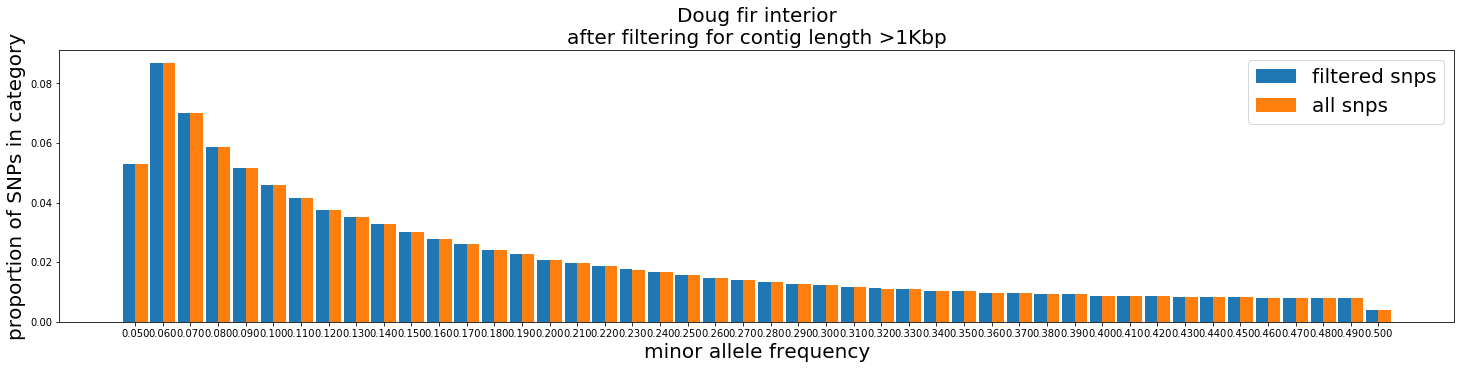

In [21]:
# compare MAF spectrum between depth-filtered and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for contig length >1Kbp')

#### reduce to no missing data 

Turns out I can't filter for no missing data, the MAF spectrum doesn't match well with MAF spectrum of all data. Filter instead for % missing below.

In [15]:
def reduce_col(col):
    """Return list of loci with no missing data for pop.FREQ col."""
    return reduced[~reduced[col].isnull()].index

In [16]:
# # get loci from each pop without missing data
# reduce_col_outs = []
# for col in nb(freqcols):
#     reduce_col_outs.append(reduce_col(col))

100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


In [17]:
# # combine returns to get loci with no missing data across pop.FREQ cols
# nomissingloci = snps.index.tolist()
# for out in nb(reduce_col_outs):
#     nomissingloci = list(set(nomissingloci).intersection(out))
# len(nomissingloci), luni(nomissingloci)

100%|██████████| 36/36 [00:18<00:00,  1.93it/s]


(384290, 384290)

In [18]:
# reduce snp table to no missing loci
reduced_nm = reduced[reduced.index.isin(nomissingloci)]
reduced_nm.head()

,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p6.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p9.FREQ,CHROM,AF,MAF
jcf7190000000004-54643,32.14%,12.28%,25.93%,42.86%,36.36%,28.57%,25.86%,42.19%,48.48%,26.32%,30.95%,55.56%,29.63%,31.43%,54.17%,35.82%,30.3%,23.21%,47.46%,35.59%,15.38%,31.37%,8.7%,25%,16.13%,26.32%,39.29%,16.44%,32.56%,14.29%,13.33%,16.33%,41.1%,35.38%,58.14%,42.86%,jcf7190000000004,0.313427,0.313427
jcf7190000000004-54644,80.7%,96.55%,84.62%,90.32%,92.54%,89.47%,90%,77.78%,87.5%,92.31%,90.48%,90.48%,76.92%,73.53%,83.33%,83.58%,68.25%,77.78%,86.44%,82.14%,53.85%,78.85%,75.56%,100%,90.16%,83.33%,84.62%,85.14%,83.72%,34.48%,95.95%,81.63%,86.11%,69.7%,78.57%,75%,jcf7190000000004,0.818951,0.181049
jcf7190000000004-54700,87.5%,96.72%,85.29%,88.68%,89.86%,88.73%,85.29%,86.67%,92.31%,94.12%,87.5%,92.06%,80.77%,74.29%,71.43%,81.67%,80.77%,77.59%,86.36%,82.54%,52.38%,80.36%,68.89%,100%,90.41%,83.75%,78.43%,87.67%,83.33%,37.74%,91.3%,75.86%,84.62%,72.58%,80.56%,77.19%,jcf7190000000004,0.819944,0.180056
jcf7190000000004-55345,89.83%,95.71%,86.67%,91.18%,92.31%,89.47%,92%,77.78%,88.89%,94.23%,88.89%,79.41%,80%,71.05%,87.5%,78.43%,86.11%,75.41%,76.74%,82.46%,55.36%,79.1%,70%,100%,87.93%,89.61%,80.3%,85.54%,86.49%,22.97%,93.51%,74.29%,87.84%,75%,81.58%,68%,jcf7190000000004,0.816159,0.183841
jcf7190000000004-289701,61.64%,83.33%,79.41%,83.33%,86.13%,67.71%,78.26%,66.27%,90.48%,85.51%,76.71%,69.03%,71.88%,87.1%,78.57%,65.12%,64.35%,66.35%,72.86%,84.35%,49.18%,69.5%,69.62%,86.11%,68.97%,75.45%,64.22%,58.7%,79.1%,32.35%,79.22%,68.32%,85.91%,68.75%,86.42%,69.86%,jcf7190000000004,0.729895,0.270105


46
46


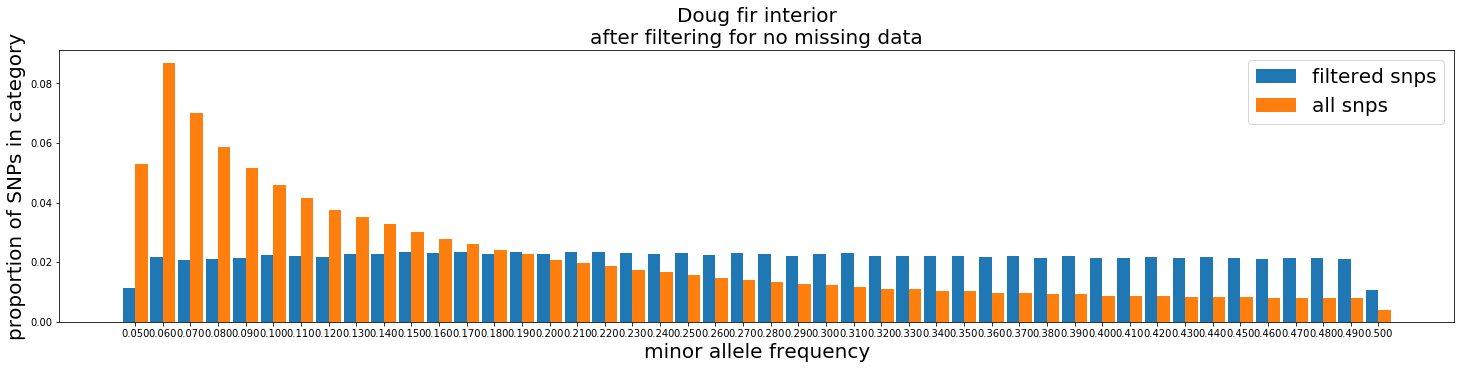

In [22]:
# # compare MAF spectrum between no-missing and precursor
# make_mafdict_fig(get_mafdict(reduced_nm['AF'], roundto=2),
#                  get_mafdict(snps['AF'], roundto=2),
#                  title='Doug fir interior\nafter filtering for no missing data')

In [23]:
del reduce_col_outs, nomissingloci, reduced_nm

#### try to reduce to X% missing data ... 

Result: any filtering resulted in a visibly different MAF spectrum

In [24]:
def filter_perc(df, perc=0.10):
    """Filter df for missing data below perc."""
    import pandas
    from tqdm.notebook import tqdm as tnb
    
    freqcols = [col for col in df.columns if '.FREQ' in col]
    keep = []
    for locus in tnb(df.index):
        if sum(df.loc[locus,:].isnull())/len(freqcols) <= perc:
            keep.append(locus)
    return keep

In [28]:
# see how filtering affects congruence between pre- and post-filtered data (figs below)
jobs = []
tosend = []
i = 0
for locus in tnb(reduced.index):
    tosend.append(locus)
    if len(tosend) == 21732 or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :]))
#         jobs.append(lview.apply_async(filter_perc, reduced.loc[tosend, :], **{'perc':0.2}))
        tosend = []
    i += 1
watch_async(jobs)

58
58


In [29]:
# gather parallel jobs
perc_loci = []
for j in jobs:
    perc_loci.extend(j.r)
len(perc_loci)

763278

46
46


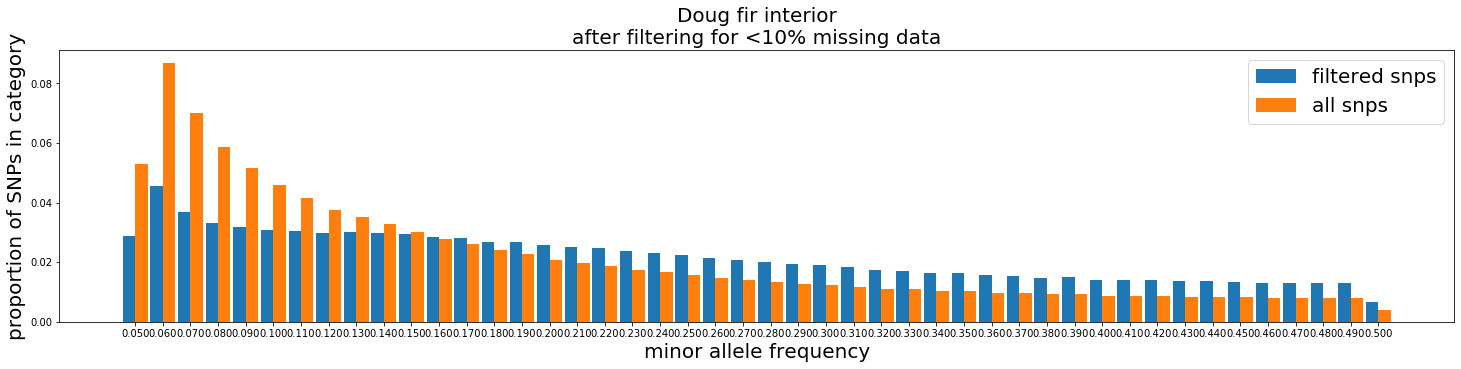

In [30]:
# compare MAF spectrum between no-missing and precursor
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for <10% missing data')

46
46


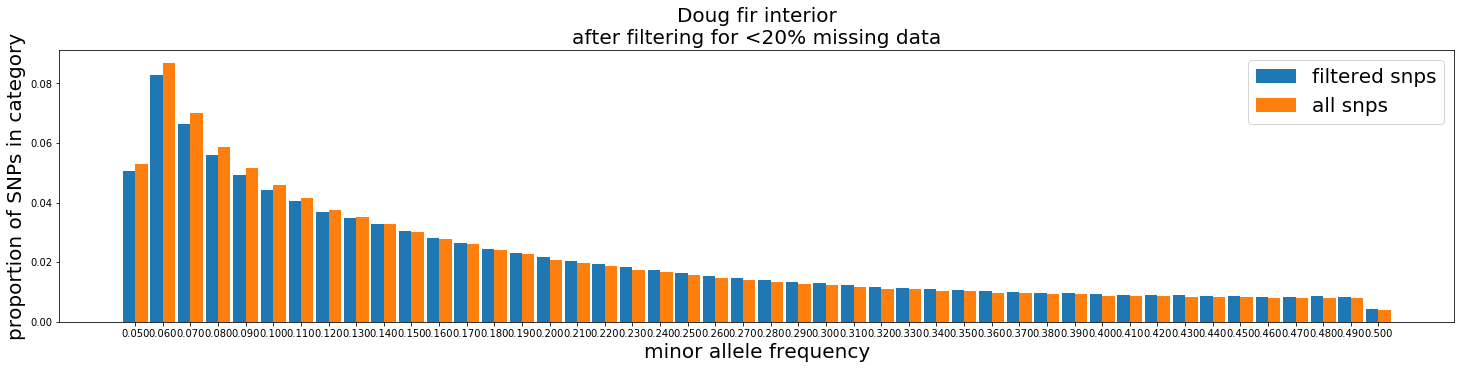

In [27]:
# compare MAF spectrum between no-missing and precursor
# MIGHT AS WELL KEEP LOCI WITHOUT FILTERING FOR MISSING DATA
make_mafdict_fig(get_mafdict(reduced.loc[perc_loci, 'AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter filtering for <20% missing data')

<center> SETTING PERC TO 0.25 MEANS NO LOCI WERE FILTERED BY MAF
    
    if I tried filtering <= 10% missing data, the MAF spectrum looked weird, leaving the code inplace. As-is (<25% missing data) will allow more contigs

#### choose one snp per contig at random

In [31]:
len(lview)

56

In [32]:
def choose_random_loci(df):
    """For each chrom in df['CHROM'], randomly choose 1 snp."""
    import pandas
    import random

    keep = []
    for chrom in uni(df['CHROM']):
        loci = df.loc[chrom, 'locus']
        if isinstance(loci, str):
            keep.append(loci)
            continue
        loci = loci.tolist()
        random.shuffle(loci)
        keep.append(loci[0])
    return keep
        
dview['uni'] = uni

In [33]:
# how many chroms do I send to a job? A: math.ceil(476.42)
luni(reduced['CHROM']), luni(reduced['CHROM'])/len(lview)

(26862, 479.67857142857144)

In [34]:
# change the index for easy sending
reduced['locus'] = reduced.index.tolist()
reduced.index = reduced['CHROM'].tolist()

In [35]:
nrow(reduced), luni(reduced['locus'])  # all unique loci names?

(1240589, 1240589)

In [36]:
# choose random loci in parallel
jobs = []
tosend = []
i = 0
numchroms = luni(reduced['CHROM'])
for chrom in tnb(uni(reduced['CHROM'])):
    tosend.append(chrom)
    if len(tosend) == 477 or (i+1)==numchroms:
        jobs.append(lview.apply_async(choose_random_loci, reduced.loc[tosend, :]))
        tosend = []
    i += 1
watch_async(jobs)

57
57


In [37]:
# get returns from jobs
randomloci = []
for j in jobs:
    randomloci.extend(j.r)
len(randomloci) == luni(reduced['CHROM'])

True

In [38]:
# reduce reduced to only randomloci
red = reduced[reduced['locus'].isin(randomloci)].copy()
print(nrow(red), len(randomloci))
red.head()

26862 26862


,DF_p18.FREQ,DF_p19.FREQ,DF_p20.FREQ,DF_p3.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p6.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p8.FREQ,DF_p9.FREQ,CHROM,AF,MAF,locus
jcf7190000000004,1.39%,10.11%,2.56%,5.48%,5.8%,13.25%,5.97%,2.99%,5.41%,4.41%,3.03%,1.41%,0%,0%,0%,5.13%,3.75%,NaN,3.28%,1.52%,NaN,2.94%,4.48%,7.14%,13.16%,NaN,NaN,8.25%,5.36%,1.82%,13.92%,9.89%,15.74%,0%,0%,2.63%,jcf7190000000004,0.050001,0.050001,jcf7190000000004-480909
jcf7190000000008,17.95%,17.39%,NaN,30.56%,9.52%,31.11%,22.86%,11.11%,NaN,60%,29.63%,16.98%,17.07%,21.21%,9.52%,28.21%,31.91%,42.42%,22.22%,30.3%,21.82%,22.73%,31.58%,17.31%,7.69%,40.62%,34%,27.08%,35.48%,28%,18.37%,48.08%,31.58%,14.29%,24.24%,26.09%,jcf7190000000008,0.258389,0.258389,jcf7190000000008-431360
jcf7190000000011,7.48%,5.67%,9.5%,5.66%,4.45%,5.65%,12.12%,9.8%,3.67%,6.89%,9.9%,11.9%,15.04%,8.85%,8.12%,14.93%,8.96%,15.24%,9.23%,4.74%,8.89%,9.59%,4.98%,6.62%,4.63%,7.28%,4.45%,2.82%,9.21%,28.86%,5.2%,5.43%,8.87%,8.88%,5.28%,11.54%,jcf7190000000011,0.086489,0.086489,jcf7190000000011-190610
jcf7190000000014,100%,100%,98.51%,100%,100%,98.85%,58.9%,0%,100%,100%,10.39%,0%,3.17%,65.22%,78.26%,0%,0%,34.34%,100%,100%,100%,0%,97.59%,100%,100%,100%,100%,100%,100%,0%,100%,100%,97.14%,66.13%,100%,62.5%,jcf7190000000014,0.711166,0.288834,jcf7190000000014-15050
jcf7190000000023,6.15%,5.88%,11.11%,12.07%,NaN,14.55%,7.69%,8.82%,NaN,3.45%,4.76%,5.88%,9.52%,11.11%,2.94%,7.69%,2.44%,6.67%,6.38%,NaN,NaN,9.46%,11.86%,1.39%,7.27%,NaN,15.87%,15.71%,16.28%,0%,10.96%,9.89%,NaN,13.33%,9.3%,7.55%,jcf7190000000023,0.085249,0.085249,jcf7190000000023-30475


In [39]:
# reset index
reduced = red.copy()
reduced.index = reduced['locus'].tolist()
reduced.shape

(26862, 40)

46
46


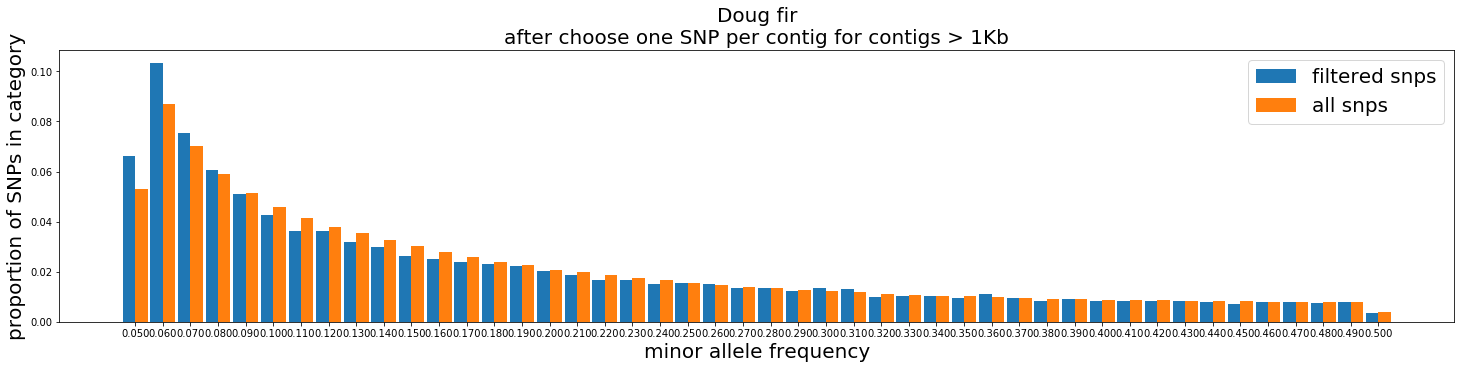

In [40]:
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter choose one SNP per contig for contigs > 1Kb')

#### get an idea of r2 values so we can determine an empirical high-end cutoff

In [41]:
len(lview)

56

In [46]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    rets = []
    for locus in myloci:
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci):
    from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
                r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [47]:
jobs = send_chunks(getr2, randomloci, 240, lview)
watch_async(jobs)

112
112


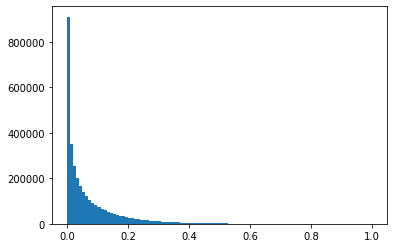

In [48]:
r2vals = []
for j in jobs:
    r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [49]:
# what is 99.99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.9999)]

0.7610354638376359

In [50]:
# get 99.9th percentile
sorted(r2vals)[math.ceil(len(r2vals)*.999)]

0.621662565701289

In [51]:
# what is 99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.99)]

0.4289482383901882

In [52]:
# what is 98th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.98)]

0.3613398279138897

In [53]:
# what is 97th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.97)]

0.3198894602925643

In [54]:
# what perc is 0.2
for i,x in enumerate(sorted(r2vals)):
    if x > 0.2:
        print(i)
        break
(i+1)/len(r2vals)

2907882


0.9064442110703486

In [55]:
# what perc is 0.3
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3:
        print(i)
        break
(i+1)/len(r2vals)

3091524


0.9636890272508417

In [56]:
# what perc is 0.3606818877742702 (to compare with jack pine)
for i,x in enumerate(sorted(r2vals)):
    if x > 0.3606818877742702:
        print(i)
        break
(i+1)/len(r2vals)

3143413


0.9798638471002749

In [57]:
# use 98th percentile
r2thresh = 0.3613398279138897

#### LD prune random loci¶

In [58]:
# number of loci starting out
reduced.shape

(26862, 40)

In [59]:
len(randomloci)

26862

In [60]:
snps.shape, reduced.shape

((1243191, 76), (26862, 40))

In [61]:
# num pops
len(freqcols)

36

In [62]:
# set up objects on engines
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))
dview['freqs'] = freqs
dview['reduced'] = None
len(freqs)

26862

In [63]:
def prune_em(compareto, locusi=None, r2thresh=0.2):
    """For a set of pairwise LD comparisons, drop one locus in pair if r2 > r2thresh."""
    from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
        nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
        r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
#         print('r2 = ', r2)
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [64]:
r2thresh

0.3613398279138897

In [65]:
# send locus along with all needed loci for pairwise comparisons to engines
# each locus (job) has r2 calculated for each of the remaining unique pairwise combinations
# so the first job compares locus1 to locus2-locusn, second job locus2 to locus3-locusn ... 
jobs = []
i = 0
for locusi in tnb(randomloci):
    tosend = randomloci[i+1:]
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))
    i += 1

In [66]:
# iterate jobs, if finished jobs are an unbroken sequenced 0:(n-1), check returns and cancel any loci iterations
    # downstream. eg if locus0 has r2 > r2thresh with locus100, drop locus100 and kill jobs[100] to save some time

# found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
# keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0  # jcount
    for j in tnb(jobs):
        if j.ready() and i-1 in found.keys() and i not in found.keys():
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(True, 26444, 26446, 3957)


3957

In [67]:
# save pruned loci
baydir = makedir(op.join(snpdir, 'baypass'))
pkl = op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3613.pkl')
pkldump(keep, pkl)

In [68]:
op.exists(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3613.pkl'))

True

46
46


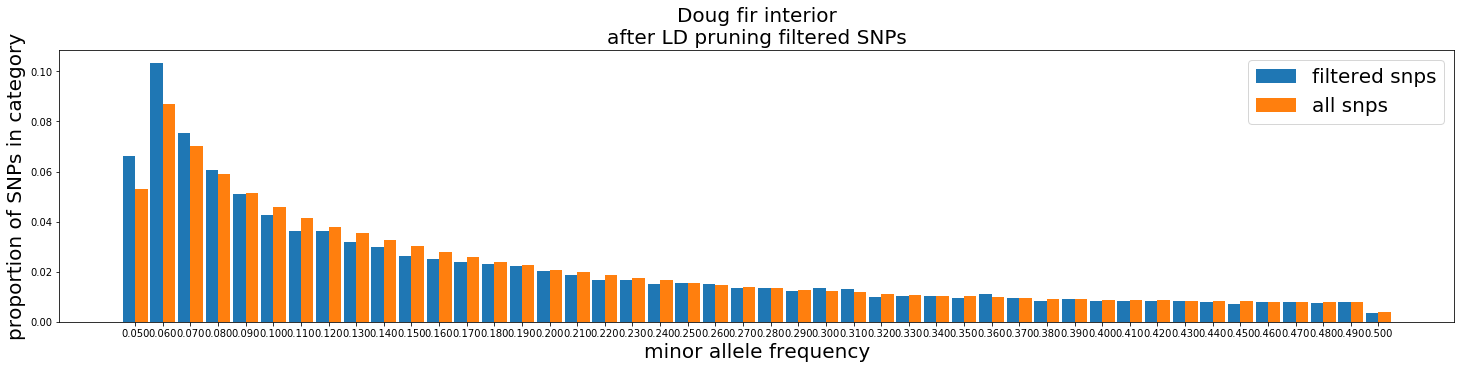

In [69]:
# compare MAF spectrum between rdpruned and precursor
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir interior\nafter LD pruning filtered SNPs')

In [70]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

# create infiles to baypass to estimate neutral structure

#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [1]:
# RESTART NOTEBOOK!

In [2]:
lview,dview = get_client()

49 49


In [3]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [5]:
# how many files currently in baydir?
fs(baydir, bnames=True, dirs=False)

['lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3613.pkl']

In [6]:
# reload pruned loci
prunedloci = pklload(op.join(baydir, 'lessthan25perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p3613.pkl'))
len(prunedloci)

3957

In [9]:
linenums

{'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt': 2696508}

In [ ]:
# get the returns, reduce to pruned loci - very important to reload without filtering for lower depth
snps = pd.concat([j.r for j in jobs])
snps.index = snps['locus'].tolist()
reduced = snps[snps['locus'].isin(prunedloci)].copy()
print(reduced.shape)
reduced.head()

In [11]:
f

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt'

In [10]:
f

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt'

In [ ]:
# read in snps, reduce to only those loci that passed pruning
snps = pd.read_table(f)
snps.index = snps['locus'].tolist()
reduced = snps[snps['locus'].isin(prunedloci)].copy()
print(reduced.shape, snps.shape, len(prunedloci))
reduced.head()

In [15]:
# triple check
len(set(prunedloci).intersection(reduced.index)) == len(prunedloci)

True

In [4]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
    assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            # this matches calculation of MAF from 001_JP_pooled_pangenome_data_explore.ipynb
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [17]:
reduced.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,DF_p20.PVAL,DF_p20.AD,DF_p20.RD,DF_p3.GT,DF_p3.GQ,DF_p3.SDP,DF_p3.DP,DF_p3.FREQ,DF_p3.PVAL,DF_p3.AD,DF_p3.RD,DF_p33.GT,DF_p33.GQ,DF_p33.SDP,DF_p33.DP,DF_p33.FREQ,...,DF_p60.GT,DF_p60.GQ,DF_p60.SDP,DF_p60.DP,DF_p60.FREQ,DF_p60.PVAL,DF_p60.AD,DF_p60.RD,DF_p61.GT,DF_p61.GQ,DF_p61.SDP,DF_p61.DP,DF_p61.FREQ,DF_p61.PVAL,DF_p61.AD,DF_p61.RD,DF_p62.GT,DF_p62.GQ,DF_p62.SDP,DF_p62.DP,DF_p62.FREQ,DF_p62.PVAL,DF_p62.AD,DF_p62.RD,DF_p7.GT,DF_p7.GQ,DF_p7.SDP,DF_p7.DP,DF_p7.FREQ,DF_p7.PVAL,DF_p7.AD,DF_p7.RD,DF_p8.GT,DF_p8.GQ,DF_p8.SDP,DF_p8.DP,DF_p8.FREQ,DF_p8.PVAL,DF_p8.AD,DF_p8.RD,DF_p9.GT,DF_p9.GQ,DF_p9.SDP,DF_p9.DP,DF_p9.FREQ,DF_p9.PVAL,DF_p9.AD,DF_p9.RD,locus,MAF
jcf7190000000056-6513,jcf7190000000056,6513,C,T,0.355713,-10.0,SNP,PASS,36,4,83,0,0,C/C,35.0,35,35.0,11.43%,5.710600e-02,4.0,31.0,C/T,72.0,44,44.0,45.45%,5.728600e-08,20.0,24.0,C/T,39.0,24,24.0,45.83%,1.104700e-04,11.0,13.0,C/T,41.0,34,34.0,35.29%,7.530200e-05,12.0,22.0,C/T,44.0,41,41.0,31.71%,...,C/T,22.0,42,42.0,16.67%,5.956300e-03,7.0,35.0,C/T,54.0,50,50.0,32%,3.658400e-06,16.0,34.0,C/T,47.0,45,45.0,31.11%,1.846200e-05,14.0,31.0,C/T,58.0,49,49.0,34.69%,1.421600e-06,17.0,32.0,C/T,41.0,32,32.0,37.5%,6.875100e-05,12.0,20.0,C/T,39.0,46,46.0,26.09%,1.072400e-04,12.0,34.0,jcf7190000000056-6513,0.355713
jcf7190000000130-186457,jcf7190000000130,186457,C,T,0.050647,-10.0,SNP,PASS,86,33,54,0,0,C/C,109.0,78,78.0,3.85%,1.225800e-01,3.0,75.0,C/T,27.0,110,110.0,8.18%,1.644700e-03,9.0,101.0,C/C,56.0,45,45.0,6.67%,1.207900e-01,3.0,42.0,C/T,24.0,98,98.0,8.16%,3.366900e-03,8.0,90.0,C/T,37.0,110,110.0,10.91%,...,C/C,208.0,139,139.0,2.88%,6.114900e-02,4.0,135.0,C/C,144.0,92,92.0,2.17%,2.486300e-01,2.0,90.0,C/C,204.0,132,132.0,2.27%,1.235700e-01,3.0,129.0,C/T,27.0,118,118.0,7.63%,1.667200e-03,9.0,109.0,C/C,125.0,91,91.0,4.4%,6.043400e-02,4.0,87.0,C/T,28.0,84,84.0,10.71%,1.558300e-03,9.0,75.0,jcf7190000000130-186457,0.050647
jcf7190000000153-69288,jcf7190000000153,69288,G,A,0.055915,-10.0,SNP,PASS,51,76,11,0,0,G/G,112.0,68,68.0,1.47%,5.000000e-01,1.0,67.0,G/A,28.0,57,57.0,15.79%,1.388000e-03,9.0,48.0,G/G,55.0,36,36.0,2.78%,5.000000e-01,1.0,35.0,G/G,66.0,42,42.0,2.38%,5.000000e-01,1.0,41.0,G/G,38.0,37,37.0,10.81%,...,G/G,34.0,32,32.0,9.38%,1.190500e-01,3.0,29.0,G/A,21.0,60,60.0,11.67%,6.492200e-03,7.0,53.0,G/A,21.0,63,63.0,11.11%,6.552900e-03,7.0,56.0,G/G,115.0,62,62.0,0%,1.000000e+00,0.0,62.0,G/G,73.0,45,45.0,2.22%,5.000000e-01,1.0,44.0,G/G,67.0,48,48.0,4.17%,2.473700e-01,2.0,46.0,jcf7190000000153-69288,0.055915
jcf7190000000176-540352,jcf7190000000176,540352,G,A,0.301308,-10.0,SNP,PASS,56,2,85,0,0,G/A,28.0,59,59.0,15.25%,1.369400e-03,9.0,50.0,G/A,148.0,112,112.0,37.5%,1.560400e-15,42.0,70.0,G/A,56.0,41,41.0,39.02%,2.053500e-06,16.0,25.0,G/A,96.0,89,89.0,31.46%,2.387600e-10,28.0,61.0,G/A,79.0,66,66.0,34.85%,...,G/A,88.0,79,79.0,32.91%,1.262700e-09,26.0,53.0,G/A,92.0,69,69.0,37.68%,5.667100e-10,26.0,43.0,G/A,74.0,74,74.0,29.73%,3.357800e-08,22.0,52.0,G/A,53.0,68,68.0,23.53%,4.711300e-06,16.0,52.0,G/A,51.0,47,47.0,31.91%,7.530600e-06,15.0,32.0,G/A,80.0,63,63.0,36.51%,9.655400e-09,23.0,40.0,jcf7190000000176-540352,0.301308
jcf7190000000178-3821,jcf7190000000178,3821,G,A,0.655211,-10.0,SNP,PASS,79,0,69,18,0,G/A,255.0,84,84.0,71.43%,2.801100e-26,60.0,24.0,G/A,255.0,94,94.0,67.02%,9.235400e-27,63.0,31.0,G/A,99.0,35,35.0,68.57%,1.189200e-10,24.0,11.0,G/A,235.0,72,72.0,75%,2.560200e-24,54.0,18.0,G/A,255.0,95,95.0,75.79%,...,G/A,255.0,116,116.0,73.28%,1.714100e-37,85.0,31.0,G/A,235.0,103,103.0,58.25%,2.864200e-24,60.0,43.0,G/A,255.0,124,124.0,74.19%,8.234400e-41,92.0,32.0,G/A,225.0,96,96.0,59.38%,3.034400e-23,57.0,39.0,G/A,177.0,75,75.0,60%,1.770300e-18,45.0,30.0,G/A,122.0,67,67.0,49.25%,5.842700e-13,33.0,34.0,jcf7190000000178-382

In [21]:
# get the gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci, numpops=36)
neutral_read_counts.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000008514-144496,46,3,97,10,26,0,79,0,50,6,51,4,53,3,62,8,20,0,47,6,52,3,37,16,32,11,38,12,29,3,35,3,36,5,48,3,67,4,44,6,58,5,47,4,71,3,44,4,77,7,24,5,56,2,61,1,28,3,21,16,61,2,55,7,47,1,45,7,41,7,71,2
jcf7190000117908-2013,359,132,530,199,142,56,387,189,415,153,315,186,538,116,391,128,107,51,401,113,377,85,438,151,299,24,373,103,262,68,446,72,520,118,632,150,357,149,408,103,452,140,605,134,289,162,362,203,420,210,399,140,353,166,319,224,341,72,551,42,547,148,418,201,475,257,363,151,486,113,504,107
jcf7190000000552-222866,0,0,87,8,35,3,0,0,55,13,33,7,50,11,0,0,21,2,30,2,27,4,44,4,25,2,0,0,31,3,44,1,40,11,33,7,43,4,50,7,0,0,66,7,65,8,56,13,53,10,38,4,50,9,0,0,39,4,78,1,27,2,63,9,73,4,0,0,52,9,41,11
jcf7190000100570-50503,35,17,56,15,18,8,30,7,44,6,31,9,57,22,28,49,26,1,22,25,23,11,33,41,16,12,32,4,19,11,30,17,45,19,38,12,38,16,44,13,53,28,44,35,27,10,47,5,44,9,31,9,43,7,50,19,32,5,45,36,48,29,42,7,50,14,45,12,34,26,52,15
jcf7190000050019-181836,72,2,0,0,0,0,92,10,69,36,96,14,106,8,78,14,51,11,0,0,78,2,143,30,0,0,64,13,46,3,82,3,137,3,114,7,76,3,0,0,0,0,125,10,0,0,120,0,139,0,109,9,101,7,157,17,86,0,123,0,173,33,128,0,143,3,110,3,0,0,75,11


In [22]:
# assert that DP = RD + AD
dpcols = [col for col in reduced.columns if '.DP' in col]
for dpcol in dpcols:
    pop = dpcol.split(".")[0]
    adcol = f"{pop}.AD"
    rdcol = f"{pop}.RD"
    assert all(reduced[dpcol] == (reduced[adcol]+reduced[rdcol]))

In [23]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [24]:
# make sure missing data makes sense
majorcols = [col for col in neutral_read_counts.columns if 'major' in col]
print(len(majorcols))  # num pops
for locus in neutral_read_counts.index:
    misscount = 0
    for col in majorcols:
        pop = col.split("-")[0]
        if neutral_read_counts.loc[locus, col] == 0 and neutral_read_counts.loc[locus, "%s-minor" % pop] == 0:
            misscount += 1
    if misscount / len(majorcols) > 0.25:
        print('crap ', locus)

36


In [25]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'interior_neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'interior_neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

In [26]:
neutral_read_counts.shape

(3957, 72)

#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

In [27]:
DIR

'/data/projects/pool_seq/DF_datasets'

In [28]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'DF_pooled_GEA/DF_pooled/pkl_files/ploidy.pkl'))['DF_pooled']
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

DF_p1 80
DF_p10 80
DF_p11 80
DF_p12 80
DF_p13 80


In [29]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80


In [30]:
len(poolsizefile.columns)  # num pops

36

In [31]:
# compare pop order to poolsizefile
neutral_read_counts.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000008514-144496,46,3,97,10,26,0,79,0,50,6,51,4,53,3,62,8,20,0,47,6,52,3,37,16,32,11,38,12,29,3,35,3,36,5,48,3,67,4,44,6,58,5,47,4,71,3,44,4,77,7,24,5,56,2,61,1,28,3,21,16,61,2,55,7,47,1,45,7,41,7,71,2
jcf7190000117908-2013,359,132,530,199,142,56,387,189,415,153,315,186,538,116,391,128,107,51,401,113,377,85,438,151,299,24,373,103,262,68,446,72,520,118,632,150,357,149,408,103,452,140,605,134,289,162,362,203,420,210,399,140,353,166,319,224,341,72,551,42,547,148,418,201,475,257,363,151,486,113,504,107
jcf7190000000552-222866,0,0,87,8,35,3,0,0,55,13,33,7,50,11,0,0,21,2,30,2,27,4,44,4,25,2,0,0,31,3,44,1,40,11,33,7,43,4,50,7,0,0,66,7,65,8,56,13,53,10,38,4,50,9,0,0,39,4,78,1,27,2,63,9,73,4,0,0,52,9,41,11
jcf7190000100570-50503,35,17,56,15,18,8,30,7,44,6,31,9,57,22,28,49,26,1,22,25,23,11,33,41,16,12,32,4,19,11,30,17,45,19,38,12,38,16,44,13,53,28,44,35,27,10,47,5,44,9,31,9,43,7,50,19,32,5,45,36,48,29,42,7,50,14,45,12,34,26,52,15
jcf7190000050019-181836,72,2,0,0,0,0,92,10,69,36,96,14,106,8,78,14,51,11,0,0,78,2,143,30,0,0,64,13,46,3,82,3,137,3,114,7,76,3,0,0,0,0,125,10,0,0,120,0,139,0,109,9,101,7,157,17,86,0,123,0,173,33,128,0,143,3,110,3,0,0,75,11


In [32]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'interior_poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'interior_poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

In [44]:
# reload to see how it was saved
poolsizefile = pd.read_table(op.join(baydir, 'interior_poolsizefile_HEADERIDX.txt'))
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80


#### <center> create random runs

#### estimate covariance matrix 

#### make shfiles for arc server - intel baypass time <<<<< g_baypass time

In [40]:
# get file names
gfile=op.join(baydir, 'interior_neutral_gfile_noheaderidx.txt')
poolsizefile=op.join(baydir, 'interior_poolsizefile_noheaderidx.txt')
all([op.exists(gfile), op.exists(poolsizefile)])

True

In [ ]:
shdir = makedir(op.join(baydir, '/neutral_runs/arch_shfiles'))

In [49]:
# create sbatch files to submit on arc server (priority is good at the moment)

# arc paths to files (I rsynced files here to arc server)
gfile = '/home/brandon.lind/interior_GEA_2nd_round/interior_neutral_gfile_noheaderidx.txt'
poolsizefile = '/home/brandon.lind/interior_GEA_2nd_round/interior_poolsizefile_noheaderidx.txt'

# create sbatch files to submit on arc server
for i in range(5):
    seed = random.randint(1,100000000)
    file = op.join(shdir, 'arc_chain_%s.sh' % str(i+1))
    cmd = f'i_baypass -gfile {gfile} -poolsizefile {poolsizefile} \
-nthreads 8 -seed {seed} -print_omega_samples -outprefix chain_{i+1} -nthreads 10'
    print(cmd,'\n')
    text = f'''#!/bin/bash
#SBATCH --job-name=chain_{i}
#SBATCH --time=12:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=10
#SBATCH --output=chain_{i}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

module load intel/2019.3

export PATH="${{PATH}}:/home/brandon.lind/src/baypass_2.2/sources"

cd /home/brandon.lind/interior_GEA_2nd_round

{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)

i_baypass -gfile /home/brandon.lind/interior_GEA_2nd_round/interior_neutral_gfile_noheaderidx.txt -poolsizefile /home/brandon.lind/interior_GEA_2nd_round/interior_poolsizefile_noheaderidx.txt -nthreads 8 -seed 53431174 -print_omega_samples -outprefix chain_1 -nthreads 10 

i_baypass -gfile /home/brandon.lind/interior_GEA_2nd_round/interior_neutral_gfile_noheaderidx.txt -poolsizefile /home/brandon.lind/interior_GEA_2nd_round/interior_poolsizefile_noheaderidx.txt -nthreads 8 -seed 35357465 -print_omega_samples -outprefix chain_2 -nthreads 10 

i_baypass -gfile /home/brandon.lind/interior_GEA_2nd_round/interior_neutral_gfile_noheaderidx.txt -poolsizefile /home/brandon.lind/interior_GEA_2nd_round/interior_poolsizefile_noheaderidx.txt -nthreads 8 -seed 34277274 -print_omega_samples -outprefix chain_3 -nthreads 10 

i_baypass -gfile /home/brandon.lind/interior_GEA_2nd_round/interior_neutral_gfile_noheaderidx.txt -poolsizefile /home/brandon.lind/interior_GEA_2nd_round/interior_poolsizefile_no

In [52]:
# once done, rsync files to netural runs dir (ndir)
ndir = makedir(op.join(baydir, 'neutral_runs'))
ndir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs'

# look at covariance matrices output from chains

In [53]:
# get the matrix files output for each chain
mfiles = fs(ndir, 'mat_omega.out')
mfiles

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_1_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_2_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_3_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_4_mat_omega.out',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/neutral_runs/chain_5_mat_omega.out']

In [54]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])

1296

In [56]:
np.sqrt(1296)  # num pops

36.0

In [57]:
from scipy.stats import pearsonr

In [58]:
# look at pairwise correlations among chains
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            print(chaini,chainj,pearsonr(matrices[chaini], matrices[chainj]))

chain_1 chain_2 (0.9771435141512166, 0.0)
chain_1 chain_3 (0.9732180557308819, 0.0)
chain_1 chain_4 (0.9846176809489202, 0.0)
chain_1 chain_5 (0.9846585028292044, 0.0)
chain_2 chain_3 (0.9769112898168248, 0.0)
chain_2 chain_4 (0.9838541321445982, 0.0)
chain_2 chain_5 (0.9846044387747641, 0.0)
chain_3 chain_4 (0.9845489477433689, 0.0)
chain_3 chain_5 (0.9752617040608504, 0.0)
chain_4 chain_5 (0.9863339218871907, 0.0)


chain_1 chain_2 0.9094231996192066 0.05422070603439985


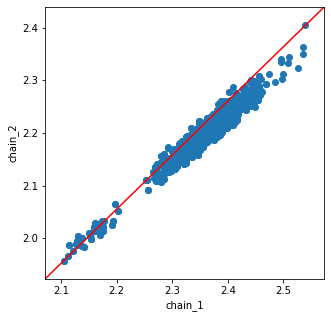

chain_1 chain_3 1.0316936448659264 0.09103668473075095


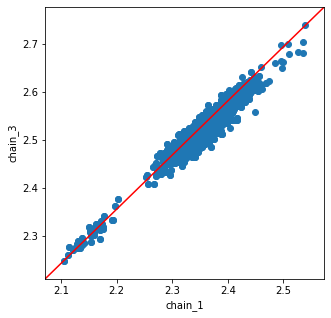

chain_1 chain_4 0.9783161429254578 0.017843011092470478


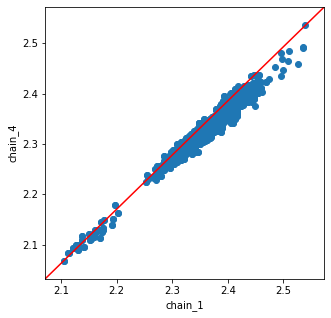

chain_1 chain_5 0.9276888519544904 0.08981478425435374


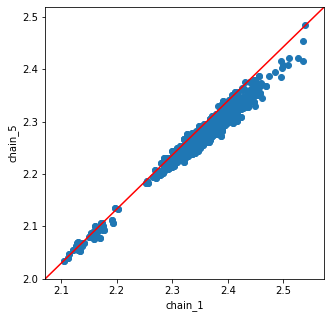

chain_2 chain_3 1.1127255264161562 0.07713194346137736


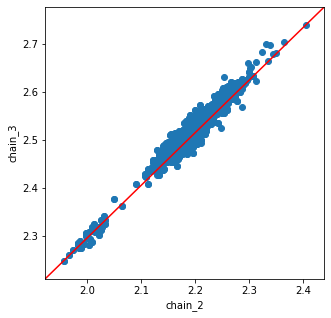

chain_2 chain_4 1.0503514232921924 0.015186125827446337


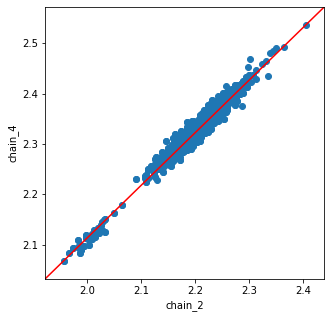

chain_2 chain_5 0.9967145916010829 0.08572135191165428


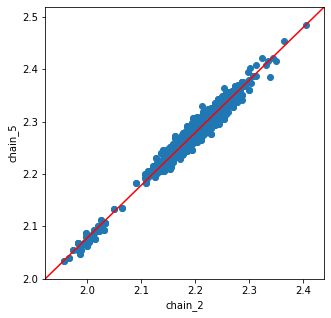

chain_3 chain_4 0.9228015263633931 -0.004432472162081263


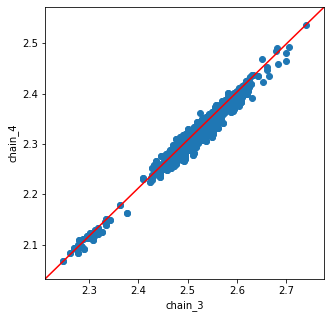

chain_3 chain_5 0.8667568357396653 0.08954769667969277


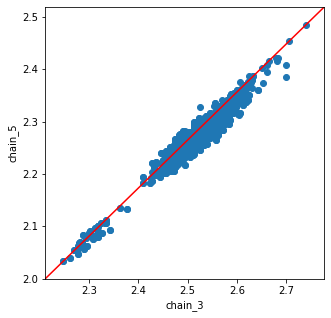

chain_4 chain_5 0.9352529402850489 0.10301126282523275


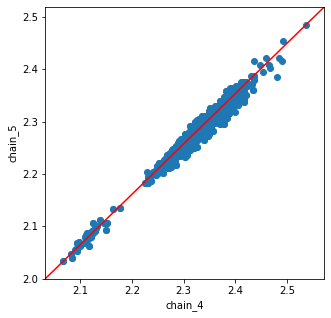

In [59]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')  # add 1:1 line in red
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

In [60]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,2.386717,2.347570,2.352072,2.334140,2.307223,2.348381,2.293852,2.281566,2.303744,2.246002,2.291831,2.244239,2.278993,2.276577,2.360083,2.289425,2.272964,2.271521,2.343805,2.304130,2.241052,2.260729,2.328645,2.319263,2.313543,2.347224,2.299037,2.300668,2.340214,2.097211,2.282888,2.307656,2.277880,2.263607,2.266353,2.309829
1,2.347570,2.422124,2.367624,2.343027,2.318822,2.356160,2.307932,2.301227,2.318574,2.269194,2.307749,2.257482,2.300364,2.290345,2.375687,2.307532,2.287789,2.282420,2.354690,2.315916,2.257227,2.282539,2.341416,2.340165,2.346906,2.358566,2.306666,2.309198,2.351142,2.111522,2.301167,2.339337,2.309323,2.279788,2.275373,2.324796
2,2.352072,2.367624,2.453550,2.359222,2.330224,2.369606,2.314606,2.307145,2.335180,2.277279,2.316622,2.266107,2.302538,2.300184,2.387580,2.308977,2.286873,2.284219,2.370998,2.331171,2.266248,2.280770,2.350524,2.343306,2.343129,2.368335,2.318651,2.319593,2.368160,2.100460,2.305619,2.340421,2.311119,2.283645,2.290812,2.326953
3,2.334140,2.343027,2.359222,2.395031,2.320994,2.356386,2.297165,2.285860,2.325829,2.259742,2.296703,2.247478,2.287350,2.282362,2.362276,2.293879,2.270653,2.269363,2.358951,2.326839,2.248523,2.264317,2.331486,2.322404,2.319696,2.345639,2.305463,2.306377,2.340091,2.079104,2.278369,2.321107,2.285452,2.267586,2.268888,2.312434
4,2.307223,2.318822,2.330224,2.320994,2.341620,2.325287,2.279616,2.266876,2.302557,2.243322,2.280577,2.230049,2.265268,2.261421,2.342280,2.273055,2.250893,2.252131,2.325598,2.295604,2.232691,2.246282,2.305165,2.295335,2.291266,2.321131,2.275907,2.276500,2.311491,2.069439,2.257967,2.292424,2.260602,2.253363,2.252854,2.291975


In [61]:
chain

'chain_5'

In [62]:
for chain,m in mats.items():
    print(chain)
    if 'chain_1' in chain:
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

chain_1
chain_2
chain_3
chain_4
chain_5


array([[12.225873, 12.009969, 12.04647 , ..., 11.58075 , 11.648161,
        11.813416],
       [12.009969, 12.413531, 12.124693, ..., 11.660288, 11.696814,
        11.886198],
       [12.04647 , 12.124693, 12.550217, ..., 11.700684, 11.780588,
        11.909201],
       ...,
       [11.58075 , 11.660288, 11.700684, ..., 11.655073, 11.49268 ,
        11.598999],
       [11.648161, 11.696814, 11.780588, ..., 11.49268 , 11.944884,
        11.620829],
       [11.813416, 11.886198, 11.909201, ..., 11.598999, 11.620829,
        12.057484]])

In [63]:
avg = summatrix / len(mats)
avg.shape

(36, 36)

In [64]:
avgmat = pd.DataFrame(avg)
print(avgmat.shape)
avgmat.head()

(36, 36)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,2.445175,2.401994,2.409294,2.392186,2.362141,2.404240,2.341623,2.330535,2.357266,2.301833,2.347841,2.301498,2.332655,2.339344,2.415021,2.343530,2.326428,2.332380,2.405129,2.368443,2.293126,2.318776,2.402799,2.382921,2.375522,2.402672,2.364717,2.360193,2.405649,2.147046,2.338773,2.358080,2.336660,2.316150,2.329632,2.362683
1,2.401994,2.482706,2.424939,2.400106,2.372547,2.410866,2.353840,2.348294,2.371554,2.323344,2.363504,2.313689,2.353866,2.353135,2.431848,2.359649,2.339741,2.344094,2.413478,2.378289,2.307999,2.337693,2.415283,2.403650,2.407201,2.412846,2.372052,2.371142,2.414228,2.160202,2.355553,2.389237,2.367835,2.332058,2.339363,2.377240
2,2.409294,2.424939,2.510043,2.418970,2.385599,2.427145,2.364756,2.355598,2.390254,2.331569,2.374326,2.322372,2.358032,2.365663,2.444535,2.364200,2.339832,2.350386,2.431590,2.396006,2.320195,2.340414,2.425626,2.406236,2.405848,2.424935,2.384608,2.382476,2.433875,2.149748,2.363814,2.389792,2.369932,2.340137,2.356118,2.381840
3,2.392186,2.400106,2.418970,2.458349,2.378769,2.417525,2.349965,2.338634,2.386290,2.316306,2.357751,2.307014,2.340964,2.346893,2.420681,2.348570,2.327322,2.334812,2.421825,2.395508,2.304358,2.324235,2.407911,2.387415,2.382227,2.402427,2.373151,2.370255,2.408230,2.131030,2.337540,2.372520,2.347153,2.325240,2.336111,2.369579
4,2.362141,2.372547,2.385599,2.378769,2.396472,2.383056,2.326151,2.313382,2.357807,2.295466,2.335598,2.286230,2.315697,2.322904,2.397570,2.324837,2.302617,2.313571,2.384232,2.358504,2.283388,2.301476,2.377743,2.356968,2.350889,2.374926,2.339095,2.336224,2.376766,2.116743,2.311473,2.341510,2.317987,2.305130,2.314177,2.345362


In [65]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
print(len(avgmatlst), len(matrices[chain]))

for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

1296 1296
chain_1 (0.9914438136027597, 0.0)
chain_2 (0.991755023151984, 0.0)
chain_3 (0.9899039414475637, 0.0)
chain_4 (0.9954809331561834, 0.0)
chain_5 (0.9934745001518485, 0.0)


In [66]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [67]:
# save average matrix
omegafile = op.join(baydir, 'interior_neutral_average_omegafile_noheaderidx.txt')
avgmat.to_csv(omegafile, sep='\t', index=False, header=False)

#### make sure pops are in same order as gfile

In [68]:
# load file to look
poolsizefile = pd.read_table(op.join(baydir, 'interior_poolsizefile_HEADERIDX.txt'))
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80


In [69]:
# load file to look
gfile = pd.read_table(op.join(baydir, 'interior_neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9


In [70]:
list(poolsizefile.columns) == gfilecols

True

In [71]:
# now apply to avgmat
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
DF_p18,2.445175,2.401994,2.409294,2.392186,2.362141,2.404240,2.341623,2.330535,2.357266,2.301833,2.347841,2.301498,2.332655,2.339344,2.415021,2.343530,2.326428,2.332380,2.405129,2.368443,2.293126,2.318776,2.402799,2.382921,2.375522,2.402672,2.364717,2.360193,2.405649,2.147046,2.338773,2.358080,2.336660,2.316150,2.329632,2.362683
DF_p19,2.401994,2.482706,2.424939,2.400106,2.372547,2.410866,2.353840,2.348294,2.371554,2.323344,2.363504,2.313689,2.353866,2.353135,2.431848,2.359649,2.339741,2.344094,2.413478,2.378289,2.307999,2.337693,2.415283,2.403650,2.407201,2.412846,2.372052,2.371142,2.414228,2.160202,2.355553,2.389237,2.367835,2.332058,2.339363,2.377240
DF_p20,2.409294,2.424939,2.510043,2.418970,2.385599,2.427145,2.364756,2.355598,2.390254,2.331569,2.374326,2.322372,2.358032,2.365663,2.444535,2.364200,2.339832,2.350386,2.431590,2.396006,2.320195,2.340414,2.425626,2.406236,2.405848,2.424935,2.384608,2.382476,2.433875,2.149748,2.363814,2.389792,2.369932,2.340137,2.356118,2.381840
DF_p3,2.392186,2.400106,2.418970,2.458349,2.378769,2.417525,2.349965,2.338634,2.386290,2.316306,2.357751,2.307014,2.340964,2.346893,2.420681,2.348570,2.327322,2.334812,2.421825,2.395508,2.304358,2.324235,2.407911,2.387415,2.382227,2.402427,2.373151,2.370255,2.408230,2.131030,2.337540,2.372520,2.347153,2.325240,2.336111,2.369579
DF_p33,2.362141,2.372547,2.385599,2.378769,2.396472,2.383056,2.326151,2.313382,2.357807,2.295466,2.335598,2.286230,2.315697,2.322904,2.397570,2.324837,2.302617,2.313571,2.384232,2.358504,2.283388,2.301476,2.377743,2.356968,2.350889,2.374926,2.339095,2.336224,2.376766,2.116743,2.311473,2.341510,2.317987,2.305130,2.314177,2.345362


In [72]:
# save pop labels
avgmat.to_csv(op.join(baydir, 'interior_neutral_average_omegafile_HEADERIDX.txt'))

# make efile

In [73]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [74]:
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80


In [78]:
# load environmental data for natural interior pops
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/df_interior-naturalpops_std_env-19variables.txt')
envdata.index = envdata['our_id'].tolist()
envdata = envdata[envdata.index.isin(poolsizefile.columns)]
envdata

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p3,3,DF_p3,FDI,-115.62,50.54,1525,-1.310317,-1.163391,-1.082583,0.507961,-0.257300,1.057829,-0.517315,-1.295532,1.307148,-1.208276,-1.361379,1.369323,-1.327171,-1.384383,-0.079997,-1.221338,-0.950264,-0.826996,-1.362662
DF_p4,4,DF_p4,FDI,-122.33,52.04,900,-0.143712,-0.178540,-0.530558,0.801722,-0.996752,-0.819974,0.956991,0.582001,0.224561,-0.112149,-0.171206,-0.060755,-0.177150,-0.043885,-0.778150,-0.553849,-0.003431,-0.346340,0.440794
DF_p5,5,DF_p5,FDI,-119.05,49.02,853,0.921449,1.065482,0.573493,0.361081,-1.196797,-1.195534,2.072959,1.892147,-0.720607,1.109342,0.848943,-1.070222,0.868324,1.009363,-1.083593,0.608875,1.149237,0.941819,1.772996
DF_p6,6,DF_p6,FDI,-125.75,52.28,460,0.464951,0.080631,0.168674,-0.153000,0.446430,-1.060333,-0.548030,1.077174,-0.372034,0.434308,0.423881,-0.481366,0.031945,0.291239,0.481020,-0.166274,0.037736,0.316966,0.821423
DF_p7,7,DF_p7,FDI,-122.13,53.98,684,-0.397322,-0.334043,-0.935376,1.389243,0.635758,1.358277,-0.855177,-1.187213,0.599947,-0.211797,-0.001181,-0.397244,-0.072602,0.195489,0.611923,-0.618445,-0.538597,-0.788543,-1.154222
DF_p8,8,DF_p8,FDI,-124.38,54.35,850,-1.056707,-1.007888,-1.303393,1.168923,-0.464490,-0.234099,-0.251121,-0.439295,1.199894,-1.008980,-0.808799,0.780468,-0.699887,-0.762009,-0.073763,-1.006019,-1.032598,-1.086550,-0.556091
DF_p9,9,DF_p9,FDI,-119.72,53.12,780,-0.650932,-0.645049,-0.677764,0.507961,-0.571657,-0.324234,0.025311,-0.196866,0.670332,-0.542885,-0.341230,0.107490,-0.177150,-0.139635,-0.304403,-0.639976,-0.867931,-0.913514,-0.383902
DF_p18,18,DF_p18,FDI,-116.83,48.33,823,1.225780,1.220985,1.162320,-0.593641,0.460719,-0.279167,-0.363742,0.561369,-1.236763,1.173631,1.188993,-0.901977,0.972872,0.961488,-0.217134,1.384024,1.190403,1.287892,0.812361
DF_p19,19,DF_p19,FDI,-116.00,45.83,686,2.088053,2.050333,2.045560,-1.181163,-0.128700,0.592134,0.404126,0.045563,-1.813248,2.154038,2.081624,-1.659078,1.704704,1.727487,-1.270598,1.922322,2.096070,2.258818,0.603921
DF_p20,20,DF_p20,FDI,-114.50,48.08,1341,0.515673,0.754476,0.720700,-0.373321,-0.825285,-0.534548,0.895561,0.649056,-0.683739,0.546814,0.338869,-0.144877,0.136492,0.147614,-0.877887,0.845726,0.614070,0.441937,0.866736


In [79]:
# triple check centered/standardized
for env in list(envdata.columns)[6:]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

MAT -1.310679959626921e-16 1.0
MWMT -7.093091546216278e-16 0.9999999999999999
MCMT 8.450030798535913e-16 0.9999999999999998
TD 1.444831908435794e-15 1.0000000000000002
MAP -1.5419764230904951e-16 1.0
MSP -1.7578531223231644e-16 0.9999999999999998
AHM 5.859510407743882e-17 1.0
SHM -9.40605618085202e-16 1.0
DD_0 -3.0839528461809902e-18 1.0
DD5 -8.789265611615822e-17 1.0
NFFD 2.9451749681028457e-16 1.0000000000000002
bFFP -5.181040781584064e-16 0.9999999999999998
eFFP -1.3168478653192829e-15 0.9999999999999999
FFP -2.4054832200211723e-16 1.0000000000000002
PAS 1.356939252319636e-16 1.0
EMT 5.959738875244764e-16 0.9999999999999998
EXT 6.908054375445419e-16 1.0
Eref -4.996003610813204e-16 1.0
CMD 2.0970879354030734e-16 1.0


In [80]:
# convert envdata to efile, making sure to order pops in same order as other files
efile = envdata.loc[poolsizefile.columns.tolist(), list(envdata.columns)[6:]]
efile.head()

,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p18,1.225780,1.220985,1.162320,-0.593641,0.460719,-0.279167,-0.363742,0.561369,-1.236763,1.173631,1.188993,-0.901977,0.972872,0.961488,-0.217134,1.384024,1.190403,1.287892,0.812361
DF_p19,2.088053,2.050333,2.045560,-1.181163,-0.128700,0.592134,0.404126,0.045563,-1.813248,2.154038,2.081624,-1.659078,1.704704,1.727487,-1.270598,1.922322,2.096070,2.258818,0.603921
DF_p20,0.515673,0.754476,0.720700,-0.373321,-0.825285,-0.534548,0.895561,0.649056,-0.683739,0.546814,0.338869,-0.144877,0.136492,0.147614,-0.877887,0.845726,0.614070,0.441937,0.866736
DF_p3,-1.310317,-1.163391,-1.082583,0.507961,-0.257300,1.057829,-0.517315,-1.295532,1.307148,-1.208276,-1.361379,1.369323,-1.327171,-1.384383,-0.079997,-1.221338,-0.950264,-0.826996,-1.362662
DF_p33,-1.665370,-1.526231,-1.340194,0.507961,0.710775,1.102896,-1.172563,-1.434800,1.766325,-1.539364,-1.573911,1.285201,-1.745361,-1.528008,1.478382,-1.436657,-1.156098,-1.115390,-1.543913


In [82]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
MAT,1.225780,2.088053,0.515673,-1.310317,-1.665370,-1.462483,0.211341,-0.853819,-1.411761,-1.056707,0.312785,-0.143712,-1.208873,-0.295878,-1.056707,0.059176,0.566395,0.160619,-0.650932,-0.701653,-1.259595,1.327224,0.921449,0.515673,2.240219,1.225780,0.617117,0.008454,0.566395,0.464951,1.022892,0.667839,0.464951,-0.397322,-1.056707,-0.650932
MWMT,1.220985,2.050333,0.754476,-1.163391,-1.526231,-1.318894,0.287968,-1.059723,-1.215225,-0.800551,0.391637,-0.178540,-2.044573,-0.541380,-0.904220,-0.385877,0.650808,0.287968,-0.748717,-0.489546,-0.852386,1.376487,1.065482,0.391637,2.257670,1.220985,0.443471,0.132465,0.443471,0.080631,0.806311,0.806311,0.547139,-0.334043,-1.007888,-0.645049
MCMT,1.162320,2.045560,0.720700,-1.082583,-1.340194,-0.824971,-0.346549,-0.824971,-1.413798,-1.303393,-0.346549,-0.530558,-0.420153,-0.456954,-1.303393,-0.236144,0.242278,0.058269,0.058269,-0.714566,-1.561005,0.941510,0.573493,1.088716,2.008758,1.051915,0.867906,0.499889,1.088716,0.168674,1.346328,1.162320,0.536691,-0.935376,-1.303393,-0.677764
TD,-0.593641,-1.181163,-0.373321,0.507961,0.507961,-0.226441,1.095483,0.140760,1.095483,1.462684,1.242363,0.801722,-2.062445,0.140760,1.242363,-0.079560,0.434521,0.361081,-1.181163,0.728282,1.903325,-0.006120,0.361081,-1.695244,-0.813962,-0.373321,-1.107723,-0.813962,-1.474924,-0.153000,-1.474924,-1.181163,-0.299881,1.389243,1.168923,0.507961
MAP,0.460719,-0.128700,-0.825285,-0.257300,0.710775,0.007045,-0.953885,-1.189653,-1.289675,-1.239664,-0.735979,-0.996752,-0.375184,-0.160850,-0.507356,-1.343259,-1.353976,0.942970,3.079166,0.496441,0.717920,-0.710974,-1.196797,-0.289450,-0.071544,0.399991,0.882242,1.410933,2.003923,0.446430,1.078715,0.600036,0.789364,0.635758,-0.464490,-0.571657


In [83]:
# save
efile.to_csv(op.join(baydir, 'interior_efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'interior_efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

In [84]:
# save a separate efile for each env so I can run the MCMC algorithm for GEA
# I ENDED UP NOT USING THESE! WE WENT WITH IS WHICH DOESN'T NEED SEPARATE EFILEs
envdir = makedir(op.join(baydir, 'individual_efiles'))
for env in efile.index:
    df = pd.DataFrame(efile.loc[env, :]).T
    df.to_csv(op.join(envdir, 'interior_%s_HEADERIDX.txt' % env), sep='\t', index=True, header=True)
    df.to_csv(op.join(envdir, 'interior_%s_noheaderidx.txt' % env), sep='\t', index=False, header=False)
df

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
CMD,0.812361,0.603921,0.866736,-1.362662,-1.543913,-1.299223,0.594859,0.567671,0.04204,-0.003273,0.232355,0.440794,-0.547028,-0.891407,-0.474527,1.492055,1.392367,-1.290161,-2.268921,-0.266088,-1.398912,1.093301,1.772996,1.464867,0.9483,0.812361,-0.130149,0.051103,-1.244848,0.821423,0.721735,-0.429214,0.513295,-1.154222,-0.556091,-0.383902


In [85]:
op.join(baydir, 'interior_efile_std_noheaderidx.txt')

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/interior_efile_std_noheaderidx.txt'

In [86]:
!echo $HOSTNAME

itbioyeaman03.ucalgary.ca


In [87]:
len(efile.columns)

36

# create gfiles for GEA from "SNP" files (ADP < 1000)

In [ ]:
# RESTART NOTEBOOK!!!

In [7]:
linenums

{'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt': 2678679}

In [5]:
# read in snps
f = keys(linenums)[0]
snps = pd.read_table(f)
snps.index = snps['locus'].tolist()
snps.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,DF_p20.PVAL,DF_p20.AD,DF_p20.RD,DF_p3.GT,DF_p3.GQ,DF_p3.SDP,DF_p3.DP,DF_p3.FREQ,DF_p3.PVAL,DF_p3.AD,DF_p3.RD,DF_p33.GT,DF_p33.GQ,DF_p33.SDP,DF_p33.DP,DF_p33.FREQ,...,DF_p60.GT,DF_p60.GQ,DF_p60.SDP,DF_p60.DP,DF_p60.FREQ,DF_p60.PVAL,DF_p60.AD,DF_p60.RD,DF_p61.GT,DF_p61.GQ,DF_p61.SDP,DF_p61.DP,DF_p61.FREQ,DF_p61.PVAL,DF_p61.AD,DF_p61.RD,DF_p62.GT,DF_p62.GQ,DF_p62.SDP,DF_p62.DP,DF_p62.FREQ,DF_p62.PVAL,DF_p62.AD,DF_p62.RD,DF_p7.GT,DF_p7.GQ,DF_p7.SDP,DF_p7.DP,DF_p7.FREQ,DF_p7.PVAL,DF_p7.AD,DF_p7.RD,DF_p8.GT,DF_p8.GQ,DF_p8.SDP,DF_p8.DP,DF_p8.FREQ,DF_p8.PVAL,DF_p8.AD,DF_p8.RD,DF_p9.GT,DF_p9.GQ,DF_p9.SDP,DF_p9.DP,DF_p9.FREQ,DF_p9.PVAL,DF_p9.AD,DF_p9.RD,locus,MAF
jcf7190000000000-77657,jcf7190000000000,77657,T,C,0.801333,-10.0,SNP,PASS,16,5,51,26,5,C/C,160.0,43,43.0,81.4%,9.593300e-17,35.0,8.0,C/C,128.0,34,34.0,82.35%,1.349000e-13,28.0,6.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,71.0,20,20.0,80%,7.708600e-08,16.0,4.0,C/C,47.0,11,11.0,90.91%,...,T/C,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,T/C,93.0,30,30.0,73.33%,4.135100e-10,22.0,8.0,C/C,82.0,19,19.0,89.47%,5.941400e-09,17.0,2.0,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,C/C,93.0,21,21.0,90.48%,4.700300e-10,19.0,2.0,T/C,49.0,17,17.0,70.59%,1.128500e-05,12.0,5.0,jcf7190000000000-77657,0.198667
jcf7190000000000-77738,jcf7190000000000,77738,T,C,0.789830,-10.0,SNP,PASS,13,2,49,28,8,T/C,103.0,32,32.0,75%,4.196400e-11,24.0,8.0,C/C,126.0,27,27.0,92.59%,2.085300e-13,25.0,2.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,T/C,29.0,9,9.0,77.78%,...,C/C,71.0,17,17.0,88.24%,7.327700e-08,15.0,2.0,T/C,55.0,17,17.0,76.47%,2.564700e-06,13.0,4.0,C/C,64.0,14,14.0,92.86%,3.739100e-07,13.0,1.0,C/C,63.0,17,17.0,82.35%,4.885100e-07,14.0,3.0,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,T/C,18.0,9,9.0,NaN,1.470600e-02,5.0,4.0,jcf7190000000000-77738,0.210170
jcf7190000000000-77764,jcf7190000000000,77764,T,C,0.934369,-10.0,SNP,PASS,12,1,28,50,8,C/C,127.0,29,29.0,89.66%,1.649600e-13,26.0,3.0,C/C,117.0,21,21.0,100%,1.857800e-12,21.0,0.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,58.0,11,11.0,100%,...,C/C,64.0,12,12.0,100%,3.698000e-07,12.0,0.0,C/C,65.0,16,16.0,87.5%,2.545400e-07,14.0,2.0,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,C/C,58.0,11,11.0,100%,1.417600e-06,11.0,0.0,C/C,52.0,10,10.0,100%,5.412500e-06,10.0,0.0,jcf7190000000000-77764,0.065631
jcf7190000000004-54349,jcf7190000000004,54349,C,T,0.552044,-10.0,SNP,PASS,20,16,67,3,1,C/T,55.0,22,22.0,63.64%,2.781700e-06,14.0,8.0,C/T,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,C/T,37.0,12,12.0,75%,0.000168,9.0,3.0,C/T,17.0,10,10.0,NaN,1.625400e-02,5.0,5.0,C/T,69.0,21,21.0,76.19%,...,C/T,79.0,27,27.0,70.37%,1.208900e-08,19.0,8.0,C/T,35.0,14,14.0,64.29%,2.898600e-04,9.0,5.0,C/T,27.0,20,20.0,40%,1.638000e-03,8.0,12.0,C/T,35.0,23,23.0,43.48%,2.806600e-04,10.0,13.0,C/T,24.0,18,18.0,38.89%,3.812300e-03,7.0,11.0,C/C,6.0,22,22.0,NaN,1.000000e+00,0.0,22.0,jcf7190000000004-54349,0.447956
jcf7190000000004-54418,jcf7190000000004,54418,T,C,0.538437,-10.0,SNP,PASS,36,1,86,0,0,T/C,89.0,39,39.0,58.97%,1.093000e-09,23.0,16.0,T/C,95.0,38,38.0,63.16%,2.566500e-10,24.0,14.0,T/C,59.0,19,19.0,73.68%,0.000001,14.0,5.0,T/C,86.0,36,36.0,61.11%,2.119400e-09,22.0,14.0,T/C,83.0,34,34.0,61.76%,...,T/C,78.0,41,41.0,51.22%,1.468200e-08,21.0,20.0,T/C,41.0,32,32.0,37.5%,6.875100e-05,12.0,20.0,T/C,66.0,37,37.0,48.65%,2.432000e-07,18.0,19.0,T/C,70.0,38,38.0,50%,9.241500e-08,19.0,19.0,T/C,45.0,21,21.0,57.14%,2.658000e-05,12.0,9.0,T/C,88.0,40,40.0,57.5%,1.298900e-09,23.0,17.0,jcf7190000000004-54418,0.461563


In [ ]:
# # read in snps in parallel
# f = keys(linenums)[0]
# nrows = 10000
# jobs = []
# for skipto in range(0, linenums[f], nrows):
#     jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
# watch_async(jobs)

In [ ]:
# # get job returns
# snps = pd.concat([j.r for j in jobs])
# snps.index = snps['locus'].tolist()
# snps.head()

In [6]:
snps.shape

(2696508, 303)

In [7]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((2696227, 303), (2696508, 303))

In [8]:
# test function
x = get_counts(reduced.index[:5], 36)
x.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000000000-77657,35,8,28,6,0,0,16,4,10,1,19,5,9,4,14,2,7,4,20,4,21,2,10,2,0,0,8,6,7,2,15,8,16,5,15,2,15,6,0,0,9,2,14,0,21,4,22,3,13,4,8,2,16,4,9,4,10,1,0,0,16,6,22,8,17,2,16,2,19,2,12,5
jcf7190000000000-77738,24,8,25,2,0,0,16,2,7,2,12,6,6,2,11,2,9,1,15,2,10,2,9,2,0,0,6,5,6,3,10,7,10,5,11,4,6,2,0,0,7,3,11,0,15,3,15,5,9,3,6,4,12,1,11,3,9,3,0,0,15,2,13,4,13,1,14,3,14,0,0,0
jcf7190000000000-77764,26,3,21,0,0,0,14,0,11,0,18,0,11,0,9,0,0,0,13,1,12,1,11,0,0,0,8,1,7,2,10,6,14,2,11,1,0,0,0,0,7,1,9,0,14,0,16,0,10,2,12,0,11,0,15,1,10,2,0,0,12,0,14,2,14,0,11,2,11,0,10,0
jcf7190000000004-54349,14,8,16,6,9,3,0,0,16,5,16,6,16,10,10,5,7,9,15,2,7,7,8,9,0,0,0,0,6,7,6,4,11,9,13,9,7,6,17,7,9,10,6,12,7,10,10,4,14,8,12,11,9,8,12,14,7,17,2,20,19,8,9,5,8,12,10,13,7,11,0,0
jcf7190000000004-54418,23,16,24,14,14,5,22,14,21,13,27,21,29,15,18,8,9,12,31,8,9,8,17,13,0,0,9,13,12,9,19,16,22,16,8,25,21,14,23,24,17,18,14,15,18,21,32,11,20,14,19,15,12,22,0,0,12,17,9,19,21,20,12,20,18,19,19,19,12,9,23,17


In [9]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

111

In [10]:
# restart engines
lview,dview = get_client()

15 15


In [11]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [13]:
# thresh to evenly distribute jobs
thresh = math.ceil(nrow(reduced) / len(lview))
thresh

179749

In [19]:
# send jobs to engines for get_counts()
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == thresh or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, *(tosend, 36)))
        tosend = []
watch_async(jobs)

15
15


In [20]:
jobs[0].r

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000000000-77657,35,8,28,6,0,0,16,4,10,1,19,5,9,4,14,2,7,4,20,4,21,2,10,2,0,0,8,6,7,2,15,8,16,5,15,2,15,6,0,0,9,2,14,0,21,4,22,3,13,4,8,2,16,4,9,4,10,1,0,0,16,6,22,8,17,2,16,2,19,2,12,5
jcf7190000000000-77738,24,8,25,2,0,0,16,2,7,2,12,6,6,2,11,2,9,1,15,2,10,2,9,2,0,0,6,5,6,3,10,7,10,5,11,4,6,2,0,0,7,3,11,0,15,3,15,5,9,3,6,4,12,1,11,3,9,3,0,0,15,2,13,4,13,1,14,3,14,0,0,0
jcf7190000000000-77764,26,3,21,0,0,0,14,0,11,0,18,0,11,0,9,0,0,0,13,1,12,1,11,0,0,0,8,1,7,2,10,6,14,2,11,1,0,0,0,0,7,1,9,0,14,0,16,0,10,2,12,0,11,0,15,1,10,2,0,0,12,0,14,2,14,0,11,2,11,0,10,0
jcf7190000000004-54349,14,8,16,6,9,3,0,0,16,5,16,6,16,10,10,5,7,9,15,2,7,7,8,9,0,0,0,0,6,7,6,4,11,9,13,9,7,6,17,7,9,10,6,12,7,10,10,4,14,8,12,11,9,8,12,14,7,17,2,20,19,8,9,5,8,12,10,13,7,11,0,0
jcf7190000000004-54418,23,16,24,14,14,5,22,14,21,13,27,21,29,15,18,8,9,12,31,8,9,8,17,13,0,0,9,13,12,9,19,16,22,16,8,25,21,14,23,24,17,18,14,15,18,21,32,11,20,14,19,15,12,22,0,0,12,17,9,19,21,20,12,20,18,19,19,19,12,9,23,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jcf7190000003826-428777,35,9,32,16,0,0,21,8,50,17,36,17,85,19,50,4,0,0,71,2,39,7,0,0,25,4,43,3,24,0,0,0,55,4,87,8,19,15,20,17,61,8,49,18,45,23,32,7,54,9,38,19,38,14,40,13,18,8,89,1,60,24,34,15,32,12,82,13,58,0,60,12
jcf7190000003826-428782,44,1,49,1,0,0,0,0,66,4,51,3,108,2,50,0,7,7,76,3,45,2,98,7,34,0,46,1,21,3,41,4,64,1,0,0,35,1,28,10,61,8,67,0,63,7,0,0,56,7,54,2,0,0,36,17,0,0,97,1,78,10,49,4,45,0,97,1,54,4,73,1
jcf7190000003826-428796,42,7,0,0,18,7,0,0,61,14,43,13,111,14,0,0,19,0,80,2,47,4,104,7,31,0,0,0,28,0,41,4,58,7,101,7,29,9,35,8,0,0,64,9,52,25,0,0,53,8,45,8,43,18,49,13,24,4,107,2,77,11,39,14,39,8,0,0,56,2,0,0
jcf7190000003826-428807,41,7,43,4,16,7,0,0,62,15,48,13,110,12,54,7,18,0,81,2,48,3,110,8,37,1,43,7,28,0,40,4,59,8,103,7,34,12,33,8,0,0,70,11,54,27,40,7,55,8,46,9,42,17,54,13,26,4,115,2,81,12,42,14,38,10,0,0,51,2,75,7


In [21]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [22]:
# make sure returns make sense
nrow(reduced) == nrow(gfile)

True

In [23]:
# make sure returns make sense
nrow(reduced) == luni(gfile.index)

True

In [24]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [37]:
# restart engines
lview,dview = get_client()

56 56


In [38]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [29]:
jobs = []
files = [op.join(baydir, 'interior_all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'interior_all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in files:
    jobs.append(lview.apply_async(write_file, *(gfile, f)))

In [30]:
watch_async(jobs)

2
2


In [31]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [32]:
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))

In [33]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles'

In [35]:
nrow(reduced)

2696227

In [39]:
# write small gfiles to parallelize baypass
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 1500 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        bname = 'interior_all_snps_ADP-lt-1000_gfile_noheaderidx.txt'.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
        smallpath = op.join(gfile_dir, bname)
        newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        pkldump(list(smallgfile.index), smallpath.replace(".txt", ".pkl"))  # save list of loci for later
        tosend = []
        jobcount += 1
watch_async(newjobs)

1798
1798


In [41]:
# make sure no errors
for j in jobs:
    assert op.exists(j.r)

In [47]:
# make sure number of files makes sense
files = fs(gfile_dir, endswith='.txt')
pkls = fs(gfile_dir, endswith='.pkl')
len(files) == len(pkls)

True

In [42]:
smallgfile.head()

,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190016526461-5448,42,17,39,16,28,10,19,10,14,22,16,16,23,19,28,19,0,0,26,31,19,26,18,14,13,19,22,22,19,24,18,28,18,19,23,21,21,22,16,16,24,36,28,23,34,20,47,27,18,9,26,15,14,12,24,28,18,29,15,23,11,18,35,27,26,14,14,23,10,10,26,27
jcf7190016526461-5454,55,2,55,2,37,3,30,1,33,2,34,1,0,0,44,2,12,0,0,0,41,2,32,1,32,2,0,0,37,4,36,7,0,0,43,3,42,2,29,2,60,1,48,2,55,2,71,3,25,2,40,1,0,0,50,0,48,4,0,0,28,2,0,0,30,3,0,0,19,0,45,9
jcf7190016526461-5455,0,0,52,4,36,2,27,2,35,1,33,0,42,0,46,0,0,0,0,0,43,2,33,0,33,1,42,1,35,4,41,2,36,1,38,4,40,2,30,3,61,0,0,0,51,3,64,9,23,2,37,3,20,3,36,13,0,0,37,0,23,3,0,0,0,0,34,4,18,2,48,3
jcf7190016526461-5461,38,21,50,3,26,11,25,4,31,5,34,1,34,5,39,9,12,2,45,9,35,5,28,4,27,6,32,11,33,3,37,4,31,6,38,7,37,4,28,5,44,15,43,6,47,6,68,10,26,5,31,8,20,2,36,12,43,7,31,5,25,2,44,11,31,3,30,5,16,4,37,15
jcf7190016526461-5471,34,20,48,3,25,9,23,6,32,6,31,1,29,5,36,9,11,2,47,7,41,4,25,4,27,7,31,10,28,4,37,4,31,5,33,8,35,3,26,6,44,12,42,4,50,6,67,10,23,6,31,5,15,2,38,11,38,8,32,5,25,3,43,10,28,0,28,5,18,4,37,14


In [45]:
# compare columns to small gfile
poolsizefile

,DF_p18,DF_p19,DF_p20,DF_p3,DF_p33,DF_p34,DF_p35,DF_p36,DF_p37,DF_p38,DF_p39,DF_p4,DF_p40,DF_p41,DF_p42,DF_p43,DF_p44,DF_p45,DF_p46,DF_p47,DF_p48,DF_p49,DF_p5,DF_p54,DF_p55,DF_p56,DF_p57,DF_p58,DF_p59,DF_p6,DF_p60,DF_p61,DF_p62,DF_p7,DF_p8,DF_p9
0,80,80,80,80,80,78,80,80,74,80,80,80,80,80,80,80,80,80,80,80,80,80,80,70,80,80,80,76,74,80,80,78,80,80,80,80


In [46]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles'

In [48]:
# count pops
smallcols = [col.split("-major")[0] for col in smallgfile.columns if 'major' in col]
len(smallcols)

36

In [49]:
# make sure pops are in same order
all(smallcols == poolsizefile.columns)

True

In [50]:
# triple check missing data < 25%
majorcols = [col for col in smallgfile if 'major' in col]
for locus in nb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break
missingcount/len(majorcols)

100%|██████████| 727/727 [00:00<00:00, 3608.63it/s]


0.2222222222222222

#### create rem SNPs gfiles

After updating the softmasked reference there are new SNPs that were once REPEATS that need to be ran

In [12]:
f

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt'

In [28]:
# read in the SNP table
snps = pd.read_table(f)
snps = snps[snps['ADP'] < 1000]
snps.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,DF_p20.PVAL,DF_p20.AD,DF_p20.RD,DF_p3.GT,DF_p3.GQ,DF_p3.SDP,DF_p3.DP,DF_p3.FREQ,DF_p3.PVAL,DF_p3.AD,DF_p3.RD,DF_p33.GT,DF_p33.GQ,DF_p33.SDP,DF_p33.DP,DF_p33.FREQ,...,DF_p60.GT,DF_p60.GQ,DF_p60.SDP,DF_p60.DP,DF_p60.FREQ,DF_p60.PVAL,DF_p60.AD,DF_p60.RD,DF_p61.GT,DF_p61.GQ,DF_p61.SDP,DF_p61.DP,DF_p61.FREQ,DF_p61.PVAL,DF_p61.AD,DF_p61.RD,DF_p62.GT,DF_p62.GQ,DF_p62.SDP,DF_p62.DP,DF_p62.FREQ,DF_p62.PVAL,DF_p62.AD,DF_p62.RD,DF_p7.GT,DF_p7.GQ,DF_p7.SDP,DF_p7.DP,DF_p7.FREQ,DF_p7.PVAL,DF_p7.AD,DF_p7.RD,DF_p8.GT,DF_p8.GQ,DF_p8.SDP,DF_p8.DP,DF_p8.FREQ,DF_p8.PVAL,DF_p8.AD,DF_p8.RD,DF_p9.GT,DF_p9.GQ,DF_p9.SDP,DF_p9.DP,DF_p9.FREQ,DF_p9.PVAL,DF_p9.AD,DF_p9.RD,locus,MAF
0,jcf7190000000000,77657,T,C,0.801333,-10.0,SNP,PASS,16,5,51,26,5,C/C,160.0,43,43.0,81.4%,9.593300e-17,35.0,8.0,C/C,128.0,34,34.0,82.35%,1.349000e-13,28.0,6.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,71.0,20,20.0,80%,7.708600e-08,16.0,4.0,C/C,47.0,11,11.0,90.91%,...,T/C,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,T/C,93.0,30,30.0,73.33%,4.135100e-10,22.0,8.0,C/C,82.0,19,19.0,89.47%,5.941400e-09,17.0,2.0,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,C/C,93.0,21,21.0,90.48%,4.700300e-10,19.0,2.0,T/C,49.0,17,17.0,70.59%,1.128500e-05,12.0,5.0,jcf7190000000000-77657,0.198667
1,jcf7190000000000,77738,T,C,0.789830,-10.0,SNP,PASS,13,2,49,28,8,T/C,103.0,32,32.0,75%,4.196400e-11,24.0,8.0,C/C,126.0,27,27.0,92.59%,2.085300e-13,25.0,2.0,./.,NaN,3,NaN,NaN,NaN,NaN,NaN,C/C,76.0,18,18.0,88.89%,2.093600e-08,16.0,2.0,T/C,29.0,9,9.0,77.78%,...,C/C,71.0,17,17.0,88.24%,7.327700e-08,15.0,2.0,T/C,55.0,17,17.0,76.47%,2.564700e-06,13.0,4.0,C/C,64.0,14,14.0,92.86%,3.739100e-07,13.0,1.0,C/C,63.0,17,17.0,82.35%,4.885100e-07,14.0,3.0,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,T/C,18.0,9,9.0,NaN,1.470600e-02,5.0,4.0,jcf7190000000000-77738,0.210170
2,jcf7190000000000,77764,T,C,0.934369,-10.0,SNP,PASS,12,1,28,50,8,C/C,127.0,29,29.0,89.66%,1.649600e-13,26.0,3.0,C/C,117.0,21,21.0,100%,1.857800e-12,21.0,0.0,./.,NaN,4,NaN,NaN,NaN,NaN,NaN,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,58.0,11,11.0,100%,...,C/C,64.0,12,12.0,100%,3.698000e-07,12.0,0.0,C/C,65.0,16,16.0,87.5%,2.545400e-07,14.0,2.0,C/C,76.0,14,14.0,100%,2.492700e-08,14.0,0.0,C/C,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,C/C,58.0,11,11.0,100%,1.417600e-06,11.0,0.0,C/C,52.0,10,10.0,100%,5.412500e-06,10.0,0.0,jcf7190000000000-77764,0.065631
3,jcf7190000000004,54349,C,T,0.552044,-10.0,SNP,PASS,20,16,67,3,1,C/T,55.0,22,22.0,63.64%,2.781700e-06,14.0,8.0,C/T,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,C/T,37.0,12,12.0,75%,0.000168,9.0,3.0,C/T,17.0,10,10.0,NaN,1.625400e-02,5.0,5.0,C/T,69.0,21,21.0,76.19%,...,C/T,79.0,27,27.0,70.37%,1.208900e-08,19.0,8.0,C/T,35.0,14,14.0,64.29%,2.898600e-04,9.0,5.0,C/T,27.0,20,20.0,40%,1.638000e-03,8.0,12.0,C/T,35.0,23,23.0,43.48%,2.806600e-04,10.0,13.0,C/T,24.0,18,18.0,38.89%,3.812300e-03,7.0,11.0,C/C,6.0,22,22.0,NaN,1.000000e+00,0.0,22.0,jcf7190000000004-54349,0.447956
4,jcf7190000000004,54418,T,C,0.538437,-10.0,SNP,PASS,36,1,86,0,0,T/C,89.0,39,39.0,58.97%,1.093000e-09,23.0,16.0,T/C,95.0,38,38.0,63.16%,2.566500e-10,24.0,14.0,T/C,59.0,19,19.0,73.68%,0.000001,14.0,5.0,T/C,86.0,36,36.0,61.11%,2.119400e-09,22.0,14.0,T/C,83.0,34,34.0,61.76%,...,T/C,78.0,41,41.0,51.22%,1.468200e-08,21.0,20.0,T/C,41.0,32,32.0,37.5%,6.875100e-05,12.0,20.0,T/C,66.0,37,37.0,48.65%,2.432000e-07,18.0,19.0,T/C,70.0,38,38.0,50%,9.241500e-08,19.0,19.0,T/C,45.0,21,21.0,57.14%,2.658000e-05,12.0,9.0,T/C,88.0,40,40.0,57.5%,1.298900e-09,23.0,17.0,jcf7190000000004-54418,0.461563


In [8]:
# get the new snps (unique SNPS that were once REPEATS across all 03 DF datasets)
newsnps = pd.read_table('/data/projects/pool_seq/DF_datasets/previous_SNP_REPEATS/new_old/new_SNPs.txt')
newsnps.head()

,locus,CHROM,POS
0,jcf7190000023348-200565,jcf7190000023348,200565
1,jcf7190000042502-71425,jcf7190000042502,71425
2,jcf7190000113769-174435,jcf7190000113769,174435
3,jcf7190000123086-22275,jcf7190000123086,22275
4,jcf7190000042502-71598,jcf7190000042502,71598


In [29]:
# reduce SNP set
# not all newsnps are in the interior dataset (some are in interior, or in varieties_combined)
# some of the newsnps might not have passed the ADP mark (didn't check)
reduced = snps[snps['locus'].isin(newsnps['locus'].tolist())].copy()
reduced.index = reduced['locus'].tolist()
reduced.shape

(2139, 303)

In [30]:
# no need to call in parallel
newgfile = get_counts(list(reduced.index), 36)
newgfile.head()

100%|██████████| 2139/2139 [00:03<00:00, 653.38it/s]


,DF_p18-major,DF_p18-minor,DF_p19-major,DF_p19-minor,DF_p20-major,DF_p20-minor,DF_p3-major,DF_p3-minor,DF_p33-major,DF_p33-minor,DF_p34-major,DF_p34-minor,DF_p35-major,DF_p35-minor,DF_p36-major,DF_p36-minor,DF_p37-major,DF_p37-minor,DF_p38-major,DF_p38-minor,DF_p39-major,DF_p39-minor,DF_p4-major,DF_p4-minor,DF_p40-major,DF_p40-minor,DF_p41-major,DF_p41-minor,DF_p42-major,DF_p42-minor,DF_p43-major,DF_p43-minor,DF_p44-major,DF_p44-minor,DF_p45-major,DF_p45-minor,DF_p46-major,DF_p46-minor,DF_p47-major,DF_p47-minor,DF_p48-major,DF_p48-minor,DF_p49-major,DF_p49-minor,DF_p5-major,DF_p5-minor,DF_p54-major,DF_p54-minor,DF_p55-major,DF_p55-minor,DF_p56-major,DF_p56-minor,DF_p57-major,DF_p57-minor,DF_p58-major,DF_p58-minor,DF_p59-major,DF_p59-minor,DF_p6-major,DF_p6-minor,DF_p60-major,DF_p60-minor,DF_p61-major,DF_p61-minor,DF_p62-major,DF_p62-minor,DF_p7-major,DF_p7-minor,DF_p8-major,DF_p8-minor,DF_p9-major,DF_p9-minor
jcf7190000000173-53983,83,7,100,2,45,8,0,0,70,16,66,22,86,0,74,2,0,0,68,0,72,0,101,1,42,0,55,1,45,0,78,9,98,1,0,0,0,0,77,21,104,0,93,4,74,11,81,15,95,10,77,8,79,13,0,0,56,11,97,0,127,4,73,12,86,2,100,0,57,0,76,2
jcf7190000000173-53990,88,0,111,0,52,0,81,3,85,2,97,0,91,0,60,27,41,0,65,0,62,8,91,15,43,3,50,4,44,3,82,4,95,15,73,3,61,0,100,0,86,20,83,16,89,2,97,0,111,0,89,1,91,0,95,0,58,7,67,31,123,12,86,0,90,2,96,8,58,1,76,8
jcf7190000000173-54077,90,8,117,7,44,4,95,9,100,13,0,0,109,3,74,43,58,1,78,2,85,14,94,21,0,0,0,0,0,0,93,7,118,30,77,12,82,4,0,0,99,32,98,15,78,4,0,0,128,8,109,10,96,8,126,0,78,13,86,44,122,17,104,7,0,0,107,19,70,4,90,7
jcf7190000000173-54079,54,42,41,86,27,21,62,42,72,41,78,42,60,52,97,19,31,33,72,9,66,31,96,18,39,9,41,18,39,9,51,48,108,35,65,26,51,34,68,42,84,44,60,53,45,37,64,56,87,51,62,55,65,41,73,52,65,27,0,0,68,72,37,76,55,76,80,42,53,22,79,17
jcf7190000000175-694991,14,19,14,11,6,11,11,8,5,10,0,0,6,12,6,6,0,0,17,1,8,8,16,13,4,6,10,6,0,0,16,8,0,0,10,7,6,10,8,7,10,6,13,8,7,8,16,8,12,10,6,8,0,0,10,14,0,0,16,1,0,0,13,6,10,13,12,6,9,11,0,0


In [31]:
cmddir = op.join(baydir, 'cmd_files')
op.exists(cmddir)

True

In [32]:
# save the full table
newgfile_file = op.join(cmddir, 'interior_all_newsnps_ADP-lt-1000_gfile_HEADERIDX.txt')
newgfile.to_csv(newgfile_file, sep='\t', index=True, header=True)

In [33]:
nrow(newgfile)

2139

In [34]:
newgfile_file

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/interior_all_newsnps_ADP-lt-1000_gfile_HEADERIDX.txt'

In [37]:
# split up newgfile into 8 jobs so I can run a full node on beluga or arc
# 8 gfiles * 5 chains = 40 cmds
newgfile_dir = makedir(op.join(cmddir, 'new_individual_gfiles'))
count = 0
for chunk in pd.read_table(newgfile_file, index_col=0, chunksize=math.ceil(nrow(newgfile)/8)):
    num = str(count).zfill(2)
    newfile = op.join(newgfile_dir, f'interior_all_newsnps_ADP-lt-1000_gfile_{num}_noheaderidx.txt')
    chunk.to_csv(newfile, header=False, index=False, sep='\t')
    pkldump(chunk.index.tolist(), newfile.replace('.txt', '.pkl'))
    count += 1
newfile

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/new_individual_gfiles/interior_all_newsnps_ADP-lt-1000_gfile_07_noheaderidx.txt'

# create commands

In [10]:
gfile_dir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/individual_gfiles'

In [11]:
# get gfiles
gfiles = fs(gfile_dir, pattern='noheader', endswith='.txt')
len(gfiles)

1798

In [13]:
# get efile
efile = op.join(baydir, 'interior_efile_std_noheaderidx.txt')
op.exists(efile)

True

In [14]:
# get omegafile and poolsize file
omegafile = op.join(baydir, 'interior_neutral_average_omegafile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'interior_poolsizefile_noheaderidx.txt')
op.exists(omegafile), op.exists(poolsizefile)

(True, True)

In [15]:
cmddir = makedir(op.join(baydir, 'cmd_files'))
cmddir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files'

#### as a rule of thumb, d0yij can be set to 1/5th the minimum pool size

In [22]:
# set compute canada dirs
cbay = '/scratch/lindb/interior'
ccmddir = op.join(cbay, 'cmd_files')
cres = op.join(ccmddir, 'results')
csh = op.join(ccmddir, 'shfiles')

In [24]:
# create baypass commands
cmds = []
for gfile in nb(gfiles):
    for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']:
        seed = random.randint(1, 100000)
        bname = op.basename(gfile).split("_noheader")[0]
        outprefix = f"{bname}_{chain}"
        cmd = f'i_baypass -gfile {gfile.replace(baydir, cbay)} \
-efile {efile.replace(baydir, cbay)} \
-omegafile {omegafile.replace(baydir, cbay)} \
-poolsizefile {poolsizefile.replace(baydir, cbay)} \
-outprefix {outprefix} \
-d0yij 8 \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-npilot 40 '
        cmds.append(cmd)
len(cmds)

100%|██████████| 1798/1798 [00:00<00:00, 7122.92it/s] 


8990

In [25]:
cmds[0]

'i_baypass -gfile /scratch/lindb/interior/individual_gfiles/interior_all_snps_ADP-lt-1000_gfile_0000_noheaderidx.txt -efile /scratch/lindb/interior/interior_efile_std_noheaderidx.txt -omegafile /scratch/lindb/interior/interior_neutral_average_omegafile_noheaderidx.txt -poolsizefile /scratch/lindb/interior/interior_poolsizefile_noheaderidx.txt -outprefix interior_all_snps_ADP-lt-1000_gfile_0000_chain_1 -d0yij 8 -seed 1063 -pilotlength 1000 -nval 50000 -npilot 40 '

In [26]:
# create catfiles for baypass commands - request 1 node with 48 CPUs
rundir = makedir(op.join(cmddir, 'run_01'))
catfiles = []
tocat = []
for i,cmd in enumerate(nb(cmds)):
    tocat.append(cmd)
    if len(tocat) == 48 or (i+1) == len(cmds):
        file = op.join(rundir, 'catfile_%s.txt' % str(len(catfiles)).zfill(4))
        with open(file, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file)
len(catfiles)

100%|██████████| 8990/8990 [00:00<00:00, 61514.51it/s]


188

In [27]:
catfiles[0]

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/run_01/catfile_0000.txt'

In [28]:
# create slurm jobs
resdir = makedir(op.join(cmddir, 'results'))
shdir = makedir(op.join(cmddir, 'shfiles'))
shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=batch_{num}
#SBATCH --time=1-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=48
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"

cd {cres}

cat {catfile.replace(cmddir, ccmddir)} | parallel -j 48 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py lindb /home/lindb

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

100%|██████████| 188/188 [00:00<00:00, 3009.31it/s]


188

In [29]:
(len(gfiles)*5)/48

187.29166666666666

#### create cmds for newsnps

In [38]:
run02dir = makedir(op.join(cmddir, 'run_02'))

In [39]:
# get newgfiles
newgfiles = fs(newgfile_dir, pattern='noheader', endswith='.txt')
len(newgfiles)

8

In [49]:
# set compute canada dirs
cbay = '/scratch/lindb/interior'
ccmddir = op.join(cbay, 'new_cmd_files')
cres = op.join(ccmddir, 'new_results')
csh = op.join(ccmddir, 'new_shfiles')
gd = op.join(ccmddir, 'new_individual_gfiles')
cd = op.join(ccmddir, 'run_02')
for d in [ccmddir, cres, csh, gd, cd]:
    print('mkdir ', d)

mkdir  /scratch/lindb/interior/new_cmd_files
mkdir  /scratch/lindb/interior/new_cmd_files/new_results
mkdir  /scratch/lindb/interior/new_cmd_files/new_shfiles
mkdir  /scratch/lindb/interior/new_cmd_files/new_individual_gfiles
mkdir  /scratch/lindb/interior/new_cmd_files/run_02


In [42]:
# get other files
efile = op.join(baydir, 'interior_efile_std_noheaderidx.txt')
omegafile = op.join(baydir, 'interior_neutral_average_omegafile_noheaderidx.txt')
poolsizefile = op.join(baydir, 'interior_poolsizefile_noheaderidx.txt')

In [50]:
# create baypass commands
cmds = []
for gfile in nb(newgfiles):
    for chain in ['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']:
        seed = random.randint(1, 100000)
        bname = op.basename(gfile).split("_noheader")[0]
        outprefix = f"{bname}_{chain}"
        cmd = f'i_baypass -gfile {gfile.replace(baydir, cbay).replace("/cmd_files/", "/new_cmd_files/")} \
-efile {efile.replace(baydir, cbay).replace("/cmd_files/", "/new_cmd_files/")} \
-omegafile {omegafile.replace(baydir, cbay).replace("/cmd_files/", "/new_cmd_files/")} \
-poolsizefile {poolsizefile.replace(baydir, cbay).replace("/cmd_files/", "/new_cmd_files/")} \
-outprefix {outprefix} \
-d0yij 8 \
-seed {seed} \
-pilotlength 1000 \
-nval 50000 \
-npilot 40 '
        cmds.append(cmd)
len(cmds)

100%|██████████| 8/8 [00:00<00:00, 13757.45it/s]


40

In [51]:
pd.read_table(gfile, header=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,35,8,56,7,28,0,46,0,41,2,44,0,54,10,40,2,17,1,50,0,34,4,51,2,22,1,36,1,33,1,50,6,50,4,41,9,54,6,34,0,40,3,58,1,48,2,63,1,41,3,45,0,40,0,39,0,26,0,43,2,48,5,52,9,43,1,42,4,47,2,44,2
1,39,8,56,7,29,0,47,0,41,2,44,0,55,10,42,2,16,1,49,0,35,4,53,3,21,1,35,1,34,1,54,6,51,4,41,9,56,6,34,0,42,3,59,1,47,3,65,1,45,3,46,0,40,0,40,0,27,0,44,2,49,6,52,9,44,3,48,4,47,2,45,3
2,53,8,65,11,31,8,45,17,50,7,52,10,74,7,56,2,0,0,0,0,44,9,46,11,27,1,0,0,0,0,0,0,65,13,0,0,59,15,40,10,46,13,50,18,58,9,62,15,0,0,0,0,46,9,52,4,27,9,52,3,54,11,77,3,53,9,69,2,37,21,56,1
3,45,15,59,18,28,10,47,15,56,4,45,18,70,8,0,0,0,0,65,0,48,4,53,4,0,0,39,3,33,12,75,4,0,0,60,15,0,0,39,8,0,0,63,7,56,8,55,21,41,16,50,8,54,3,41,16,32,2,39,15,0,0,66,15,51,10,61,11,53,3,0,0
4,44,19,51,24,27,9,41,15,27,27,47,18,48,35,47,17,16,3,46,16,32,23,35,28,23,7,37,8,28,18,59,22,49,25,45,28,38,34,31,19,31,31,63,13,33,26,45,34,49,11,37,21,35,21,42,18,25,12,50,7,47,16,56,24,48,12,41,30,41,16,39,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0,0,41,13,0,0,34,7,26,8,0,0,21,19,20,8,0,0,17,16,16,15,15,12,0,0,16,25,14,9,30,19,0,0,23,18,9,6,27,7,26,8,31,24,6,6,20,23,29,10,35,10,18,8,0,0,38,4,48,16,31,17,23,9,21,16,28,11,15,17,8,10
259,33,3,55,3,18,0,0,0,27,4,19,0,40,2,32,1,12,0,32,0,34,4,27,1,21,1,28,1,20,3,47,2,28,4,43,1,23,0,31,0,26,0,49,1,12,6,31,2,0,0,39,0,31,2,35,3,40,0,57,0,39,9,31,2,0,0,38,2,28,0,27,0
260,19,10,26,17,0,0,15,13,15,12,0,0,20,11,19,15,0,0,14,10,11,20,11,10,0,0,6,15,6,7,14,15,15,14,13,21,12,14,0,0,16,9,10,19,13,12,6,19,17,8,0,0,12,14,23,10,26,3,23,13,11,23,13,8,11,12,12,8,11,16,7,10
261,88,4,94,6,60,0,77,3,89,8,95,2,94,13,78,12,55,3,77,4,71,10,75,23,22,16,61,15,42,8,78,24,90,18,87,16,67,0,86,0,94,30,112,8,72,7,109,7,111,3,87,0,101,0,124,0,64,3,68,44,94,20,108,1,124,1,89,18,68,9,64,10


In [52]:
cmds[0]

'i_baypass -gfile /scratch/lindb/interior/new_cmd_files/new_individual_gfiles/interior_all_newsnps_ADP-lt-1000_gfile_00_noheaderidx.txt -efile /scratch/lindb/interior/interior_efile_std_noheaderidx.txt -omegafile /scratch/lindb/interior/interior_neutral_average_omegafile_noheaderidx.txt -poolsizefile /scratch/lindb/interior/interior_poolsizefile_noheaderidx.txt -outprefix interior_all_newsnps_ADP-lt-1000_gfile_00_chain_1 -d0yij 8 -seed 28362 -pilotlength 1000 -nval 50000 -npilot 40 '

In [53]:
# create catfiles for baypass commands - request 1 node 48 CPUs
catfiles = []
tocat = []
for i,cmd in enumerate(nb(cmds)):
    tocat.append(cmd)
    if len(tocat) == 48 or (i+1) == len(cmds):
        file = op.join(run02dir, 'catfile_%s.txt' % str(len(catfiles)).zfill(4))
        with open(file, 'w') as o:
            o.write('\n'.join(tocat))
        tocat = []
        catfiles.append(file)
len(catfiles)

100%|██████████| 40/40 [00:00<00:00, 59346.36it/s]


1

In [54]:
# create slurm jobs
# instead of 48 CPUs use 40
resdir = makedir(op.join(cmddir, 'new_results'))
shdir = makedir(op.join(cmddir, 'new_shfiles'))
shfiles = []
for catfile in nb(catfiles):
    num = catfile.split("_")[-1].split(".")[0]
    shfile = op.join(shdir, op.basename(f"batch_{num}.sh"))
    with open(shfile, 'w') as o:
        text = f'''#!/bin/bash
#SBATCH --job-name=batch_{num}
#SBATCH --time=1-00:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=25
#SBATCH --cpus-per-task=40
#SBATCH --output=batch_{num}_%j.out
#SBATCH --mail-user=lindb@vcu.edu
#SBATCH --mail-type=FAIL

export PATH="${{PATH}}:/project/def-saitken/programs/baypass_2.2/sources"

cd {cres}

cat {catfile.replace(cmddir, ccmddir)} | parallel -j 40 --progress

source $HOME/py3/bin/activate
cd $HOME/pipeline
python balance_queue.py lindb /home/lindb

'''
        o.write("%s" % text)
    shfiles.append(shfile)
len(shfiles)

100%|██████████| 1/1 [00:00<00:00, 2447.09it/s]


1

In [ ]:
# I transferred all by hand (scp)

# Transfer files to cedar/beluga/graham/arc to run baypass

In [2]:
baydir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass'

In [32]:
# get infiles
files = fs(baydir, 'nohead', exclude=['all_snps', 'neutral_gfile'])
files

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/interior_efile_std_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/interior_neutral_average_omegafile_noheaderidx.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/interior_poolsizefile_noheaderidx.txt']

In [33]:
gfile_dir = op.join(baydir, 'individual_gfiles')

In [34]:
# get gfiles
gfiles = fs(gfile_dir, exclude='.pkl')
files.extend(gfiles)
len(files)

1801

In [35]:
rundir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/run_01'

In [36]:
shdir

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/shfiles'

In [37]:
# get catfiles and shfiles
files.extend(fs(shdir, endswith='.sh'))
files.extend(fs(rundir, endswith='.txt'))
len(files)

2177

In [75]:
lview,dview = get_client()

56 56


In [76]:
def exe(src, dst):
    import subprocess
    import shutil
    out = subprocess.check_output([shutil.which('rsync'), '-azv', src, dst])
    return out

In [77]:
files[0]

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/interior_efile_std_noheaderidx.txt'

In [78]:
cbay

'/scratch/lindb/interior'

In [44]:
arcbay = '/home/brandon.lind/interior_GEA_2nd_round'

In [58]:
syncs = []
dstdirs = []
arcdirs = []
for src in files:
    dst = 'cedar:' + src.replace(baydir, cbay)
    dstdirs.append(op.dirname(src.replace(baydir, cbay)))
    syncs.append((src, dst))
    
    dst = 'beluga:' + src.replace(baydir, cbay)
    syncs.append((src, dst))
    
    dst = 'graham:' + src.replace(baydir, cbay)
    syncs.append((src, dst))
    
    dst = 'arc:' + src.replace(baydir, arcbay)
    arcdirs.append(op.dirname(src.replace(baydir, arcbay)))
    syncs.append((src, dst))
dst

'arc:/home/brandon.lind/interior_GEA_2nd_round/cmd_files/run_01/catfile_0187.txt'

In [57]:
for d in uni(dstdirs):
    print('mkdir -p', d)

mkdir -p /scratch/lindb/interior
mkdir -p /scratch/lindb/interior/cmd_files/shfiles
mkdir -p /scratch/lindb/interior/individual_gfiles
mkdir -p /scratch/lindb/interior/cmd_files/run_01


In [59]:
for d in uni(arcdirs):
    print('mkdir -p ', d)

mkdir -p  /home/brandon.lind/interior_GEA_2nd_round
mkdir -p  /home/brandon.lind/interior_GEA_2nd_round/cmd_files/run_01
mkdir -p  /home/brandon.lind/interior_GEA_2nd_round/cmd_files/shfiles
mkdir -p  /home/brandon.lind/interior_GEA_2nd_round/individual_gfiles


In [60]:
len(syncs)

8708

In [62]:
syncs[-1]

('/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety/03_maf-p05_RD-recalculated_FDI/baypass/cmd_files/run_01/catfile_0187.txt',
 'arc:/home/brandon.lind/interior_GEA_2nd_round/cmd_files/run_01/catfile_0187.txt')

In [63]:
exe(*syncs[-1])

b'sending incremental file list\ncatfile_0187.txt\n\nsent 480 bytes  received 35 bytes  147.14 bytes/sec\ntotal size is 6,535  speedup is 12.69\n'

In [81]:
def make_jobs(inputs:list, cmd, lview) -> list:
    """Send each arg from inputs to a function command; async."""
    print(f"making jobs for {cmd.__name__}")
    jobs = []
    for arg in tnb(inputs):
        jobs.append(lview.apply_async(cmd, *arg))
    return jobs

In [82]:
# rsync in parallel
jobs = make_jobs(syncs, exe, lview)
watch_async(jobs, sleep=1)

8708
8708


In [96]:
# make sure no errors
redos = []
for i,j in enumerate(jobs):
    if j.ready():
        try:
            x=j.r
        except:
            redos.append(i)
len(redos)

0

In [94]:
jobs = make_jobs([syncs[i] for i in redos], exe, lview)

making jobs for exe


In [91]:
watch_async(jobs, sleep=1)

188
188
